In [1]:
import wrangle_zillow

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import scipy.stats as stats

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Pulling in all data for explore

In [2]:
df = wrangle_zillow.get_zillow()


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   airconditioningtypeid         13615 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   52319 non-null  float64
 5   bedroomcnt                    52319 non-null  float64
 6   buildingclasstypeid           0 non-null      float64
 7   buildingqualitytypeid         33654 non-null  float64
 8   calculatedbathnbr             52184 non-null  float64
 9   decktypeid                    389 non-null    float64
 10  finishedfloor1squarefeet      4371 non-null   float64
 11  calculatedfinishedsquarefeet  52238 non-null  float64
 12  finishedsquarefeet12          52073 non-null  float64
 13  f

In [4]:
df = wrangle_zillow.clean_zillow(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42137 entries, 0 to 52318
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   bathrooms            42137 non-null  float16       
 1   bedrooms             42137 non-null  uint8         
 2   square_footage       42137 non-null  uint16        
 3   county               42137 non-null  object        
 4   latitude             42137 non-null  float64       
 5   longitude            42137 non-null  float64       
 6   lot_size             42137 non-null  float64       
 7   yearbuilt            42137 non-null  uint16        
 8   structure_tax_value  42137 non-null  float64       
 9   tax_value            42137 non-null  float64       
 10  land_tax_value       42137 non-null  float64       
 11  taxamount            42137 non-null  float64       
 12  logerror             42137 non-null  float64       
 13  transactiondate      42137 non-

In [6]:
columns_to_scale = df.select_dtypes('number').columns

In [7]:
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.prepare_all_data(df, columns_to_scale)

Validating data is the split appropriately and the same

In [8]:
train.shape, validate.shape, test.shape

((23596, 14), (10113, 14), (8428, 14))

In [9]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((23596, 14), (10113, 14), (8428, 14))

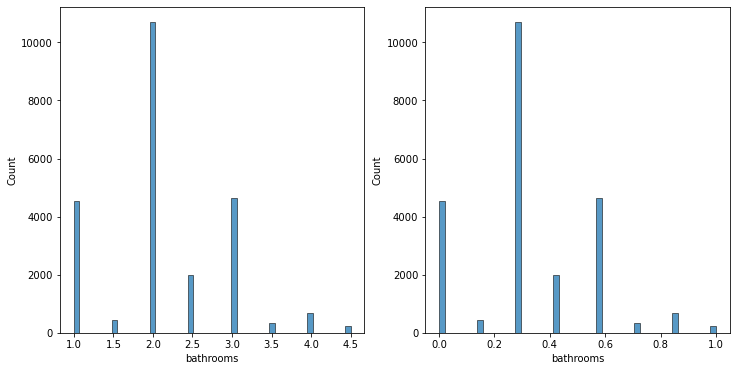

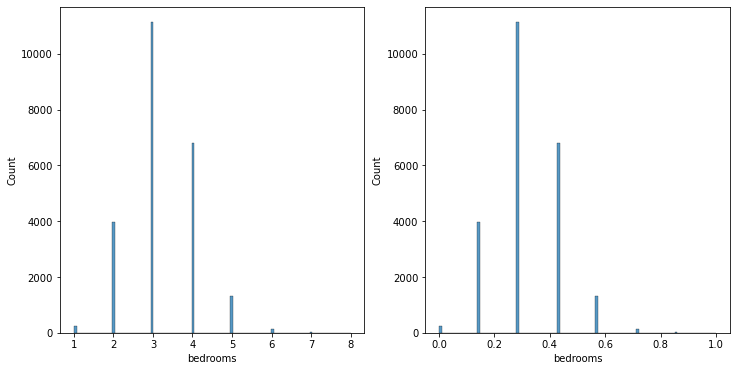

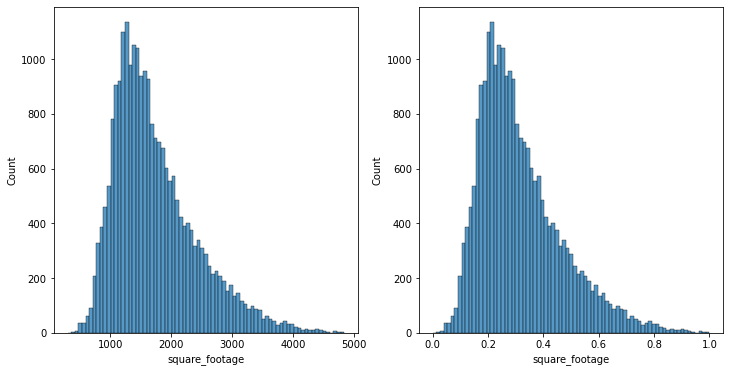

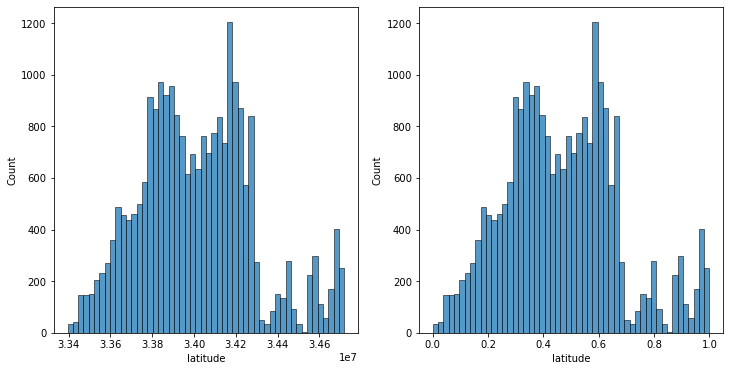

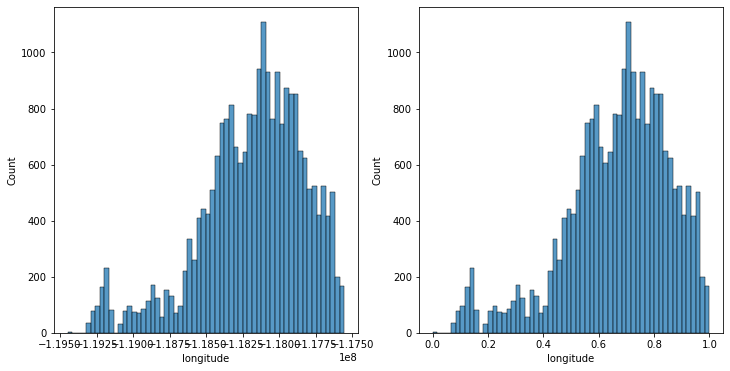

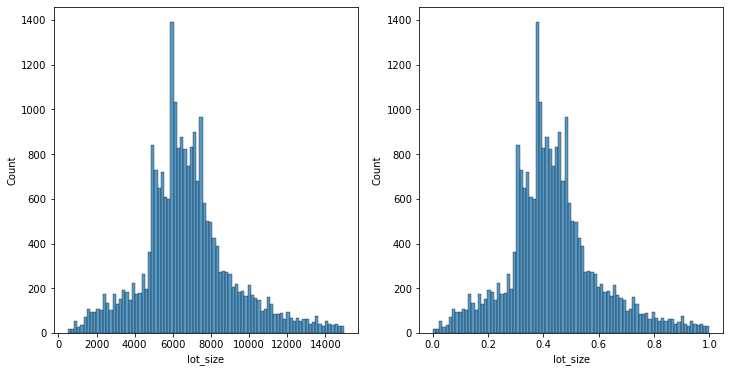

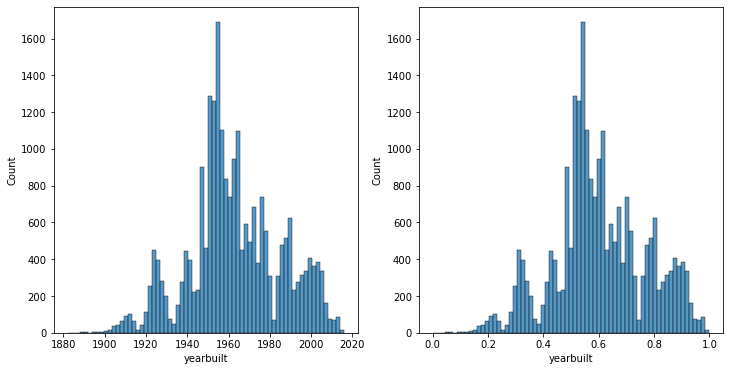

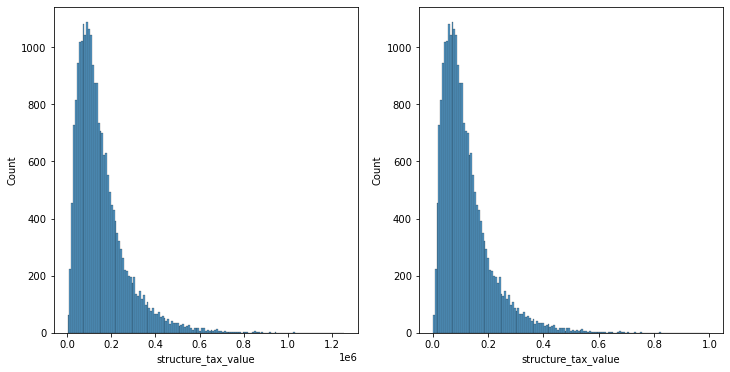

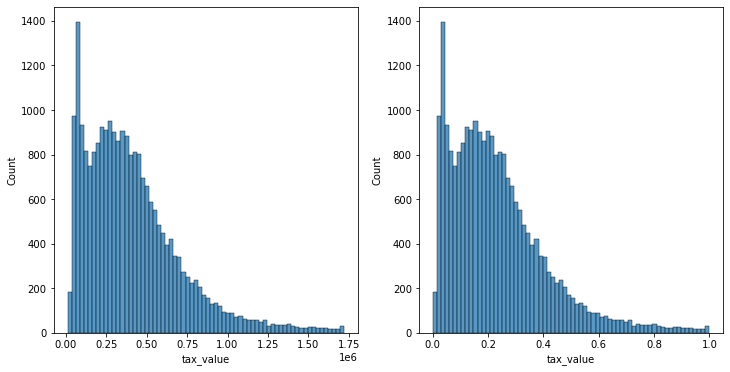

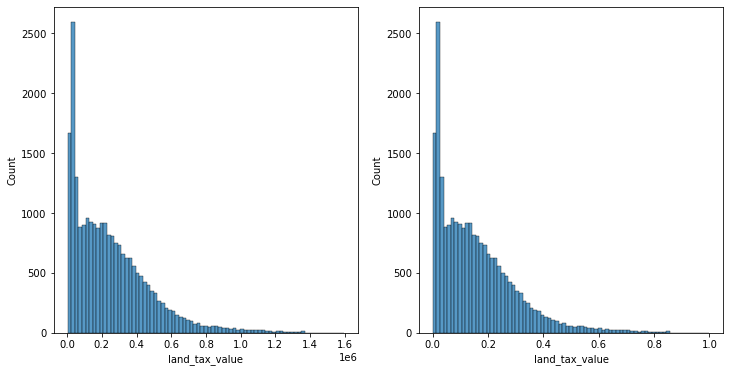

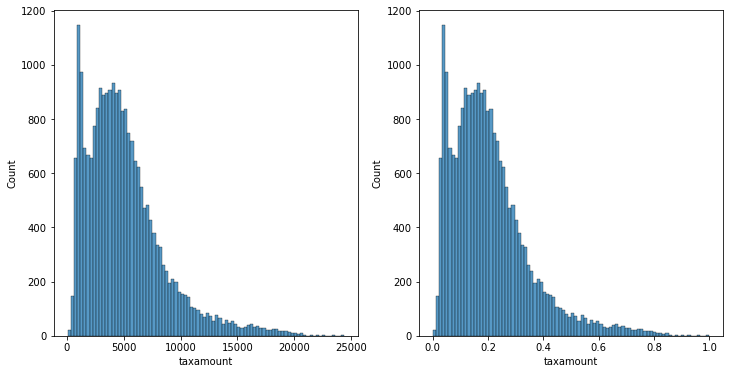

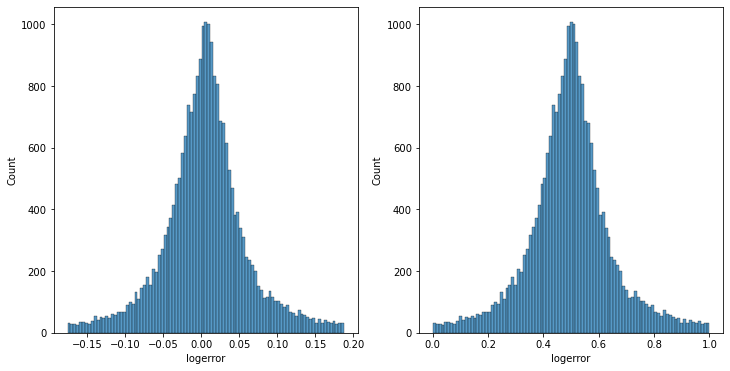

In [10]:
for column in columns_to_scale:
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    sns.histplot(train[column])
    plt.subplot(122)
    sns.histplot(train_scaled[column])
    plt.show()

Data is split and scaled appropriately, I can begin EDA.

# Exploration

My thoughts from before the data analysis.

- I know some of these values are going to be highly correlated to one another, eg. bathroomcnt and calculatedbathroomnbr and fullbathcnt.
- I suspect that larger homes, larger properties and higher taxvaluedollarcnt will be most correlated to the target logerror.
- I'm curious to see if location by lat and long have any effect on home prices or log error.
- There are categorical columns that are encoded as numerical here, as well as discrete numerical columns; I'm curious to see how there might be a relationship in any of these.

Beginning with bivariate visualizations of all continuous variables

In [11]:
# Writing a function that plots pairs of continuous variables to visualize all the potential relationships.
from itertools import combinations

def plot_variable_pairs(df, to_drop = None):
    '''
    This function takes in a dataframe and plots all possible numerical data pairs in scatterplots with a regression 
    line. The function only plots unique combinations of pairs, not permutations, e.g. only prints column a by 
    column b, but leaves out column b by column a. This reduces clutter and runtime.
    
    arguments: df - A dataframe with numerical columns
               to_drop - a list of columns to drop or not include in the plots
    returns: This function returns nothing; it merely plots out the scatterplots
    '''
    
    if to_drop == None:
        columns_to_plot = df.select_dtypes(include = 'number').columns
        plot_tuples = []
        for i in combinations(columns_to_plot,2):
            plot_tuples.append(i)

        for i in plot_tuples:
            sns.lmplot(x = i[0], y = i[1], data = df, line_kws={'color': '#FF5E13', 'linewidth': 3},  height=5, aspect=1.5)
            plt.plot()
            plt.show()
    else:
        columns_to_plot = df.select_dtypes(include = 'number').columns.drop(to_drop)
        plot_tuples = []
        for i in combinations(columns_to_plot,2):
            plot_tuples.append(i)

        for i in plot_tuples:
            sns.lmplot(x = i[0], y = i[1], data = df, line_kws={'color': '#FF5E13', 'linewidth': 3},  height=5, aspect=1.5)
            plt.plot()
            plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23596 entries, 32749 to 10595
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   bathrooms            23596 non-null  float16       
 1   bedrooms             23596 non-null  uint8         
 2   square_footage       23596 non-null  uint16        
 3   county               23596 non-null  object        
 4   latitude             23596 non-null  float64       
 5   longitude            23596 non-null  float64       
 6   lot_size             23596 non-null  float64       
 7   yearbuilt            23596 non-null  uint16        
 8   structure_tax_value  23596 non-null  float64       
 9   tax_value            23596 non-null  float64       
 10  land_tax_value       23596 non-null  float64       
 11  taxamount            23596 non-null  float64       
 12  logerror             23596 non-null  float64       
 13  transactiondate      23596 

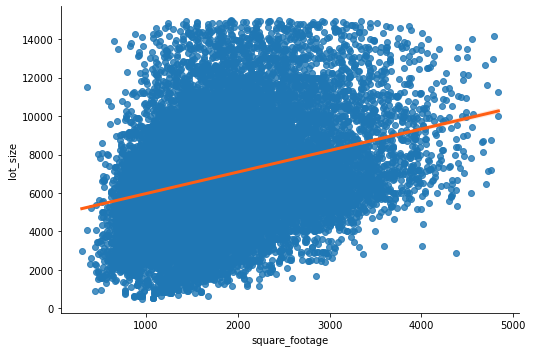

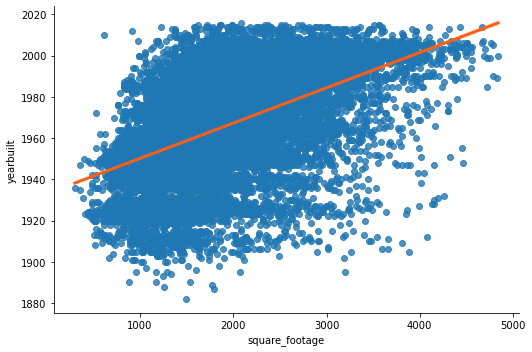

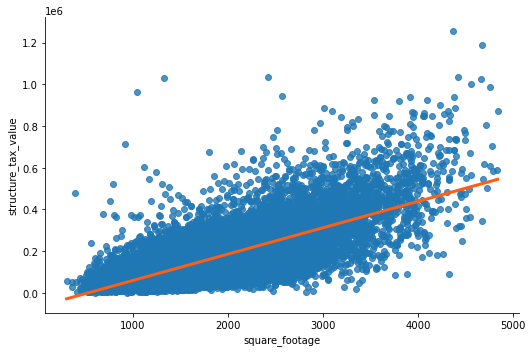

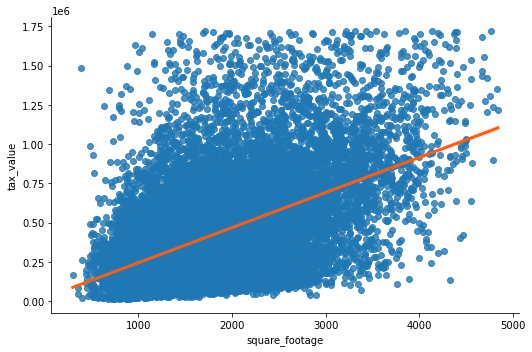

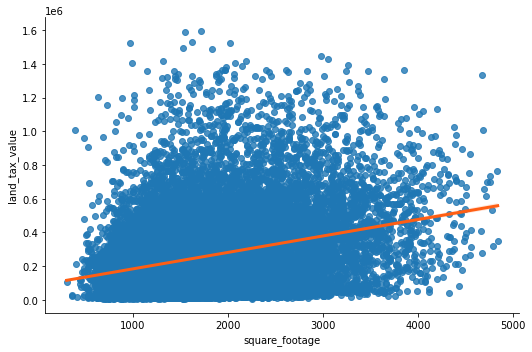

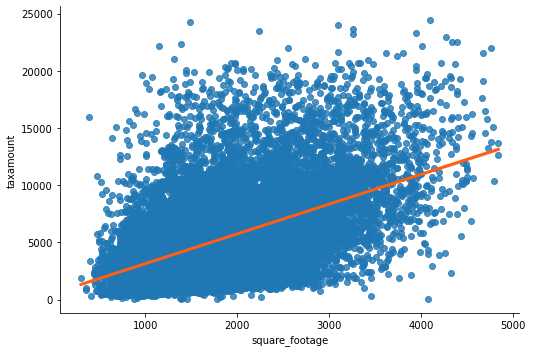

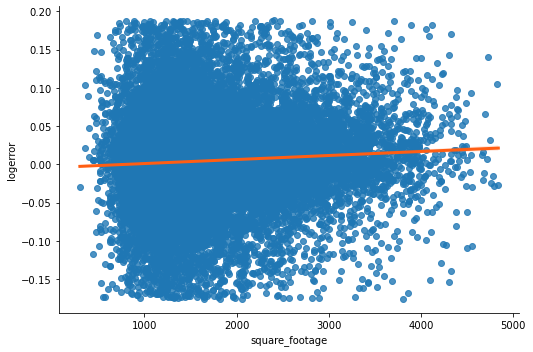

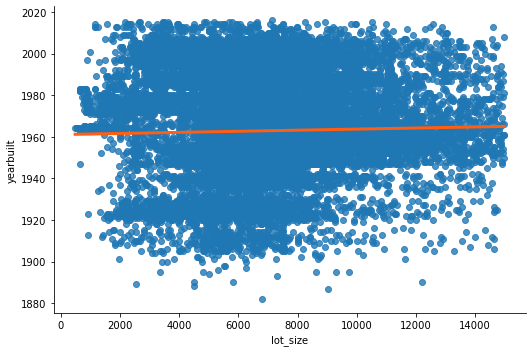

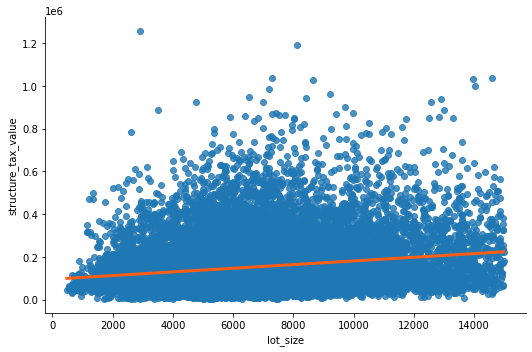

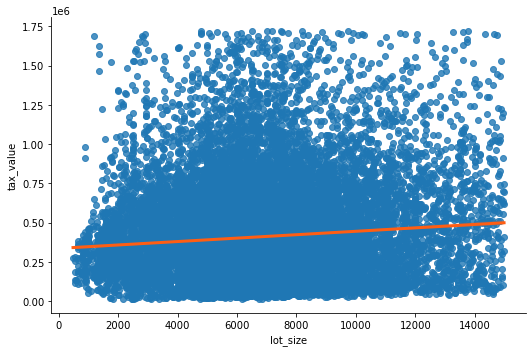

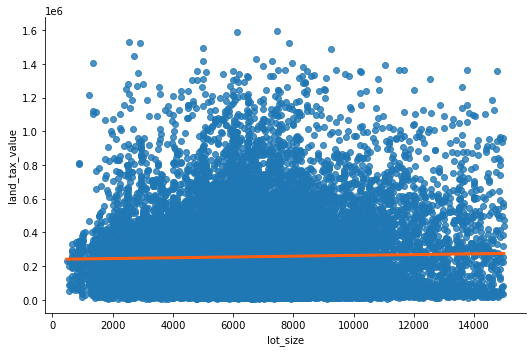

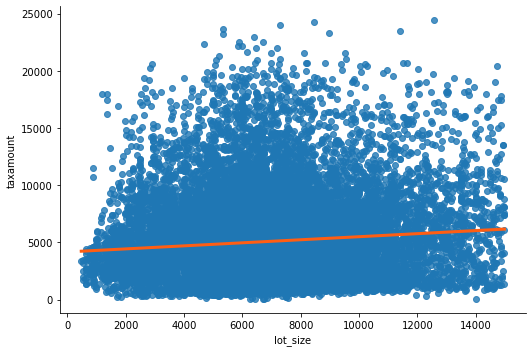

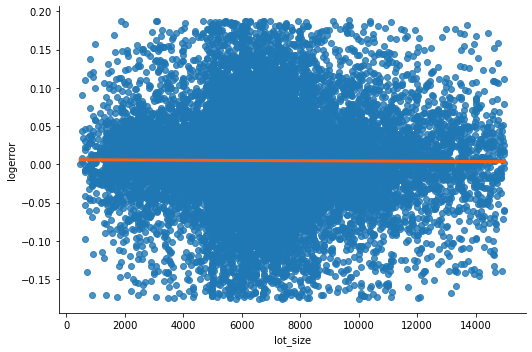

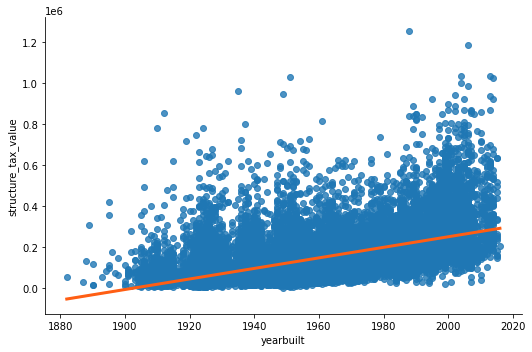

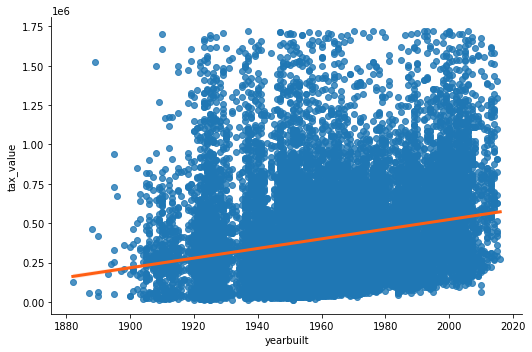

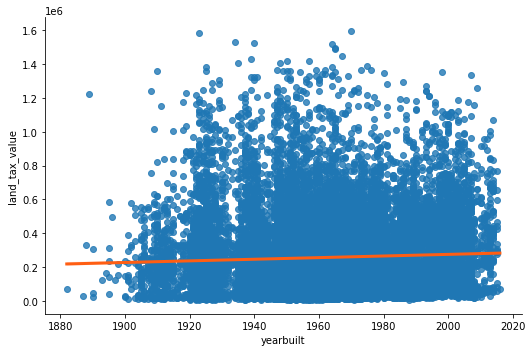

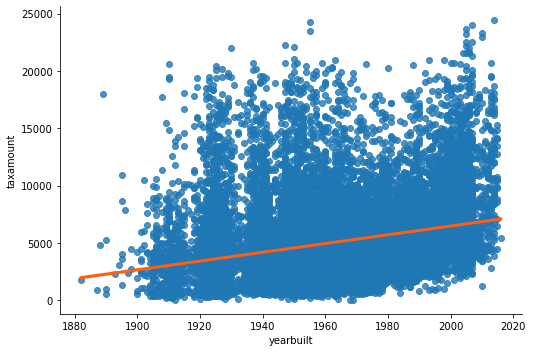

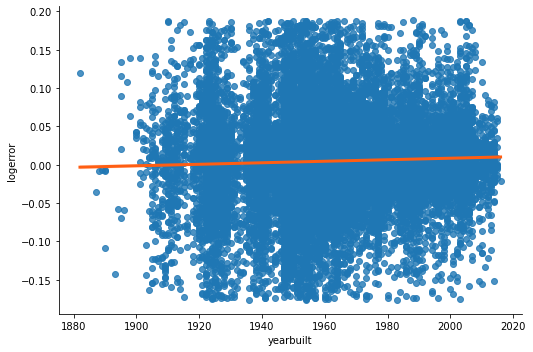

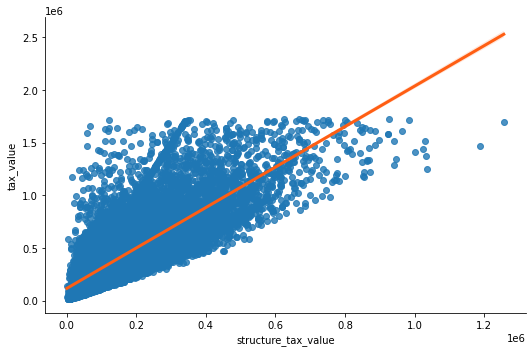

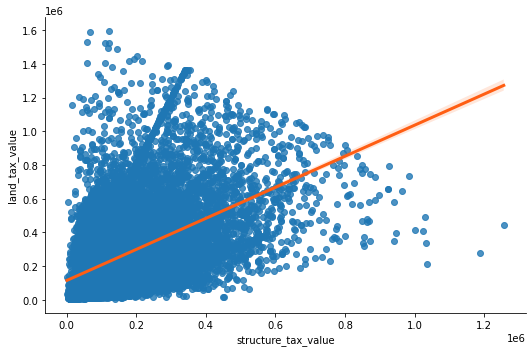

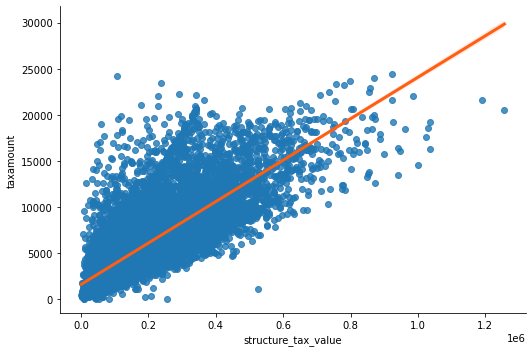

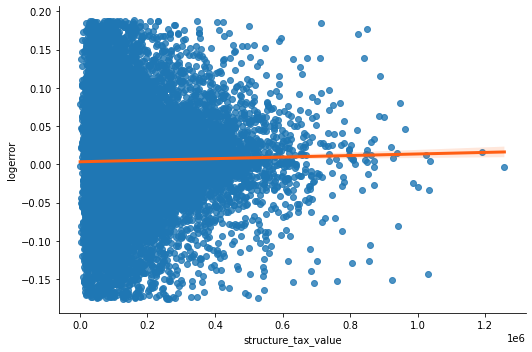

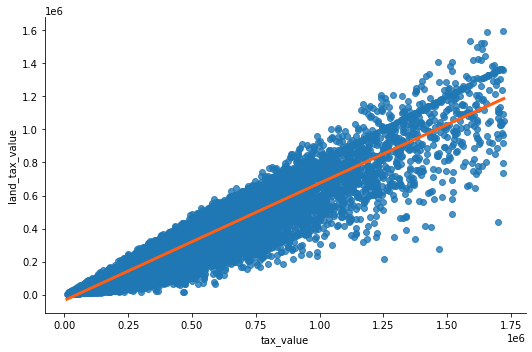

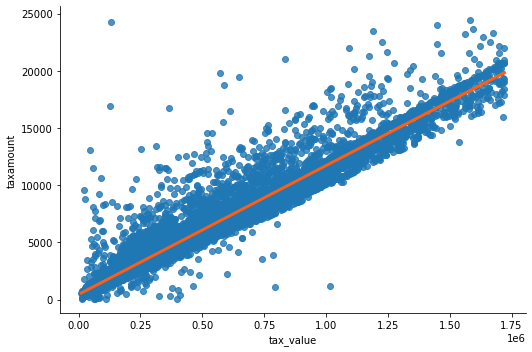

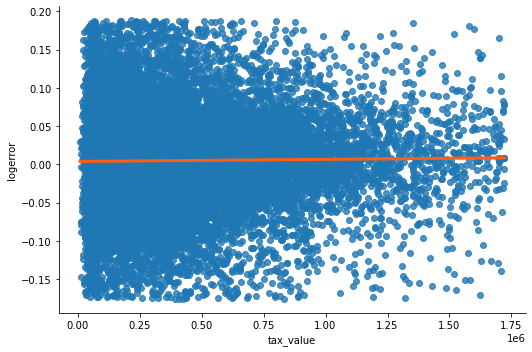

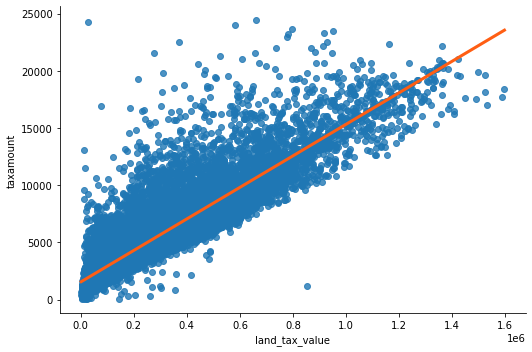

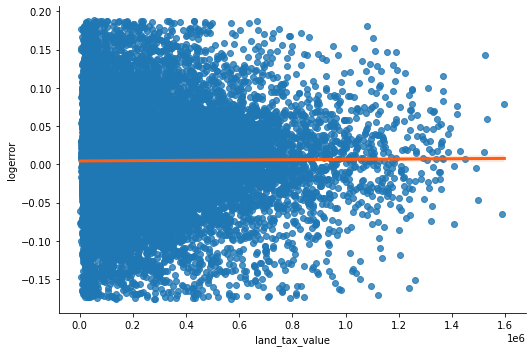

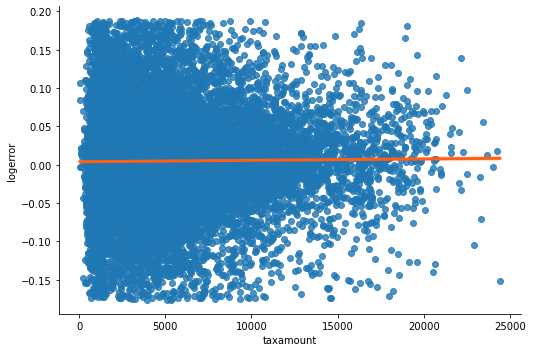

In [14]:
# Just going to plot actual continuous variables not numerical/discrete data
plot_variable_pairs(train, to_drop = ['bathrooms','bedrooms','latitude','longitude'])

Now I want to isolate the correlations on the with the target alone to see what it looks like.

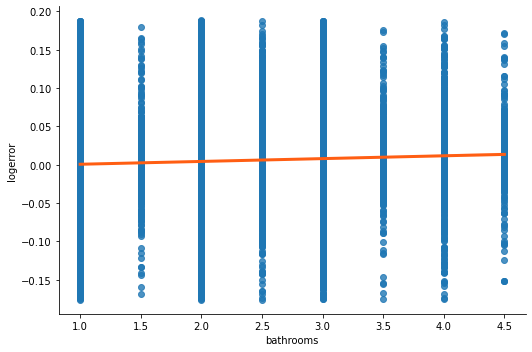

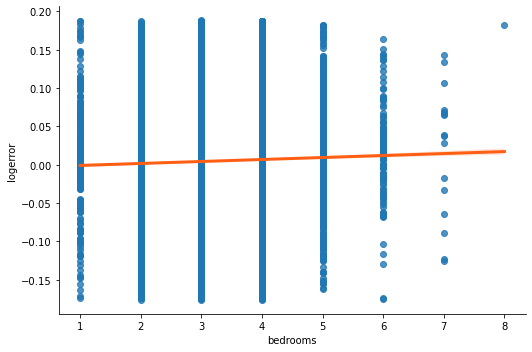

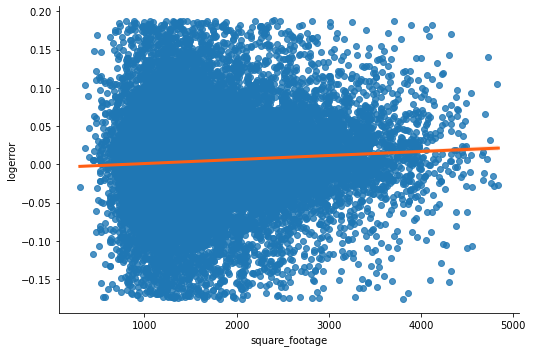

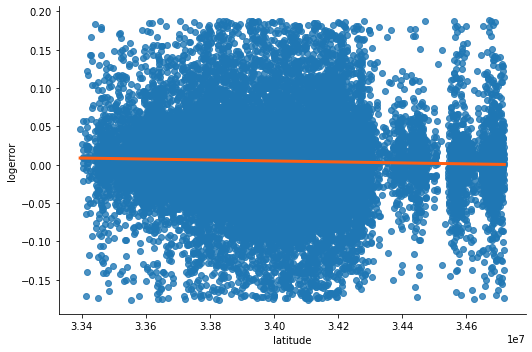

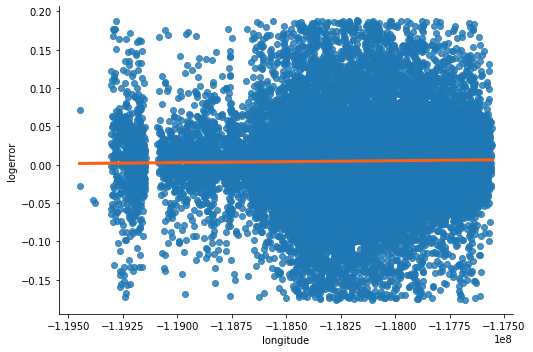

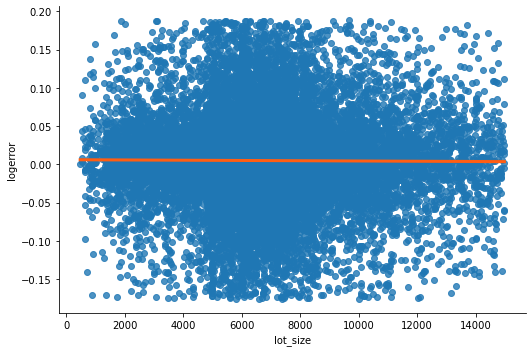

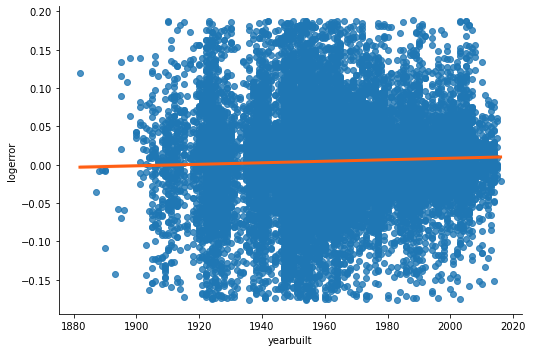

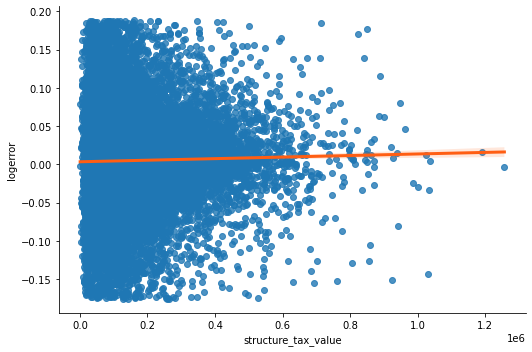

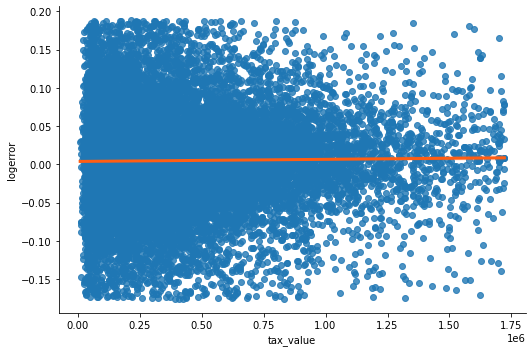

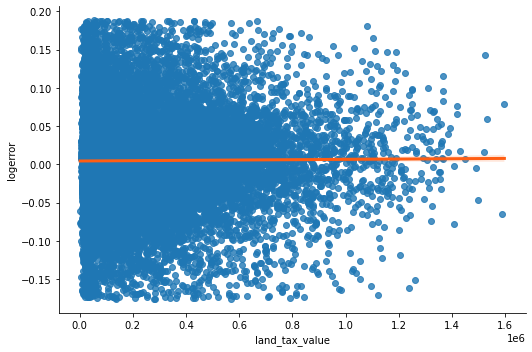

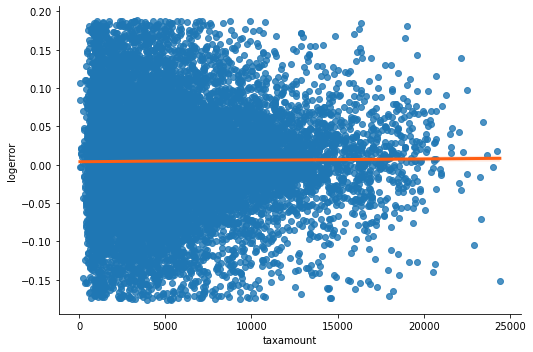

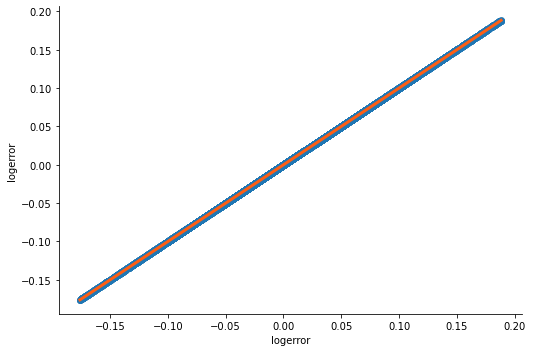

In [15]:
for column in train.select_dtypes(include = 'number').columns:
    sns.lmplot(x = column, y = 'logerror', data = train, line_kws={'color': '#FF5E13', 'linewidth': 3},  height=5, aspect=1.5)

In [16]:
#Looking at the homes wiith the largest log error
train[train.logerror > (train.logerror.max()*.9)].sort_values('logerror')

bathrooms  bedrooms  square_footage       county    latitude  \
13296        2.0         3            1558  los_angeles  34174318.0   
17972        2.0         3            1976  los_angeles  33831425.0   
51297        1.0         2            1228  los_angeles  34068069.0   
51788        2.0         4            2298  los_angeles  34173237.0   
27827        2.0         3            1667  los_angeles  34177890.0   
...          ...       ...             ...          ...         ...   
8856         1.0         4            2466      ventura  34281397.0   
50034        2.0         4            1381       orange  33839214.0   
29789        1.0         1            1064  los_angeles  33849616.0   
2996         2.0         4            1681  los_angeles  34014621.0   
12052        2.0         3            2411  los_angeles  34671797.0   

         longitude  lot_size  yearbuilt  structure_tax_value  tax_value  \
13296 -118515121.0    5700.0       1949             140156.0   480405.0   
17972 -118364838.0    5603.0       1955             204455.0   789119.0   
51297 -118361417.0    5422.0       1926             150043.0   311093.0   
51788 -118586733.0    8387.0       1960             191202.0   306153.0   
27827 -118574119.0    8934.0       1957              58795.0   115937.0   
...            ...       ...        ...                  ...        ...   
8856  -119281245.0    3075.0       1910             231000.0   660000.0   
50034 -117972496.0    7923.0       1958              86503.0   263603.0   
29789 -118170556.0    5481.0       1942              82000.0   410000.0   
2996  -118337060.0    6143.0       1942              35598.0    68087.0   
12052 -118176430.0    9687.0       1988             160397.0   213933.0   

       land_tax_value  taxamount  logerror transactiondate  
13296        340249.0    5846.64  0.169494      2017-03-24  
17972        584664.0    9007.77  0.169507      2017-04-17  
51297        161050.0    3801.32  0.169555      2017-09-13  
51788        114951.0    3924.78  0.169639      2017-09-15  
27827         57142.0    1548.91  0.169642      2017-05-31  
...               ...        ...       ...             ...  
8856         429000.0    6978.54  0.187863      2017-02-28  
50034        177100.0    3245.02  0.187886      2017-09-06  
29789        328000.0    4990.63  0.187908      2017-06-07  
2996          32489.0    1019.18  0.187955      2017-01-20  
12052         53536.0    3358.15  0.188233      2017-03-17  

[163 rows x 14 columns]

I need to explore this more in clustering

Exploring correlations now.

<AxesSubplot:>

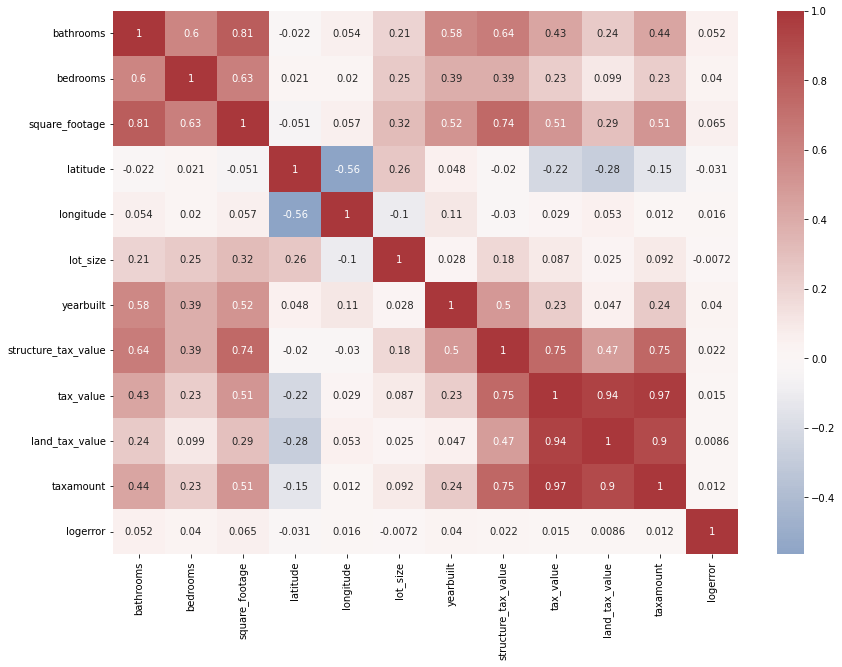

In [17]:
plt.figure(figsize=(14,10))
sns.heatmap(data=train.corr(), annot=True, cmap = "vlag", center = 0)

**Takeaways:** 
- Nothing correlates highly to logerror
- calculatedbathnbr, bathroomcnt, and fullbathcnt are essentially all the same thing, I can rewrite wrangle_zillow.py to drop 2 of the 3. I will retain bathroomcnt and drop the other two. (When running in the future, I've already dropped these in the wrangle_zillow.py file so they won't show up here.)
- taxvaluedollarcnt, taxamount and landtaxvaluedollarcnt are all highly correlated to one another.

In [18]:
 # Writing a function that plots continuous variables with categoricals separated out to visualize all the potential relationships.

def plot_categorical_and_continuous_vars(df, continuous, categorical):
    '''
    This function takes in a dataframe, a list of continuous variables, and a list of categorical variables and does 
    3 plots for each unique combination of categorical and continuous variable.
    
    Arguments: df - a dataframe consisting of continuous and categorical columns
    '''
    plot_list = []
    for cat in categorical:
        for cont in continuous:
            plot_list.append([cat, cont])
    
    for i in plot_list:
        plt.figure(figsize=(18, 5))
        plt.subplot(131)
        sns.boxplot(x=i[0], y=i[1], data=df)
        plt.subplot(132)
        sns.stripplot(x=i[0], y=i[1], data=df)
        plt.subplot(133)
        sns.violinplot(x=i[0], y=i[1], data=df)
#         sns.barplot(x=i[0], y=i[1], data=df)
        plt.show()

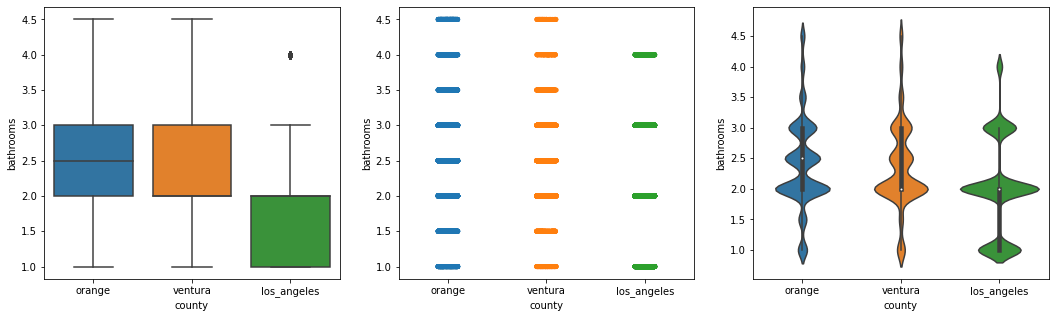

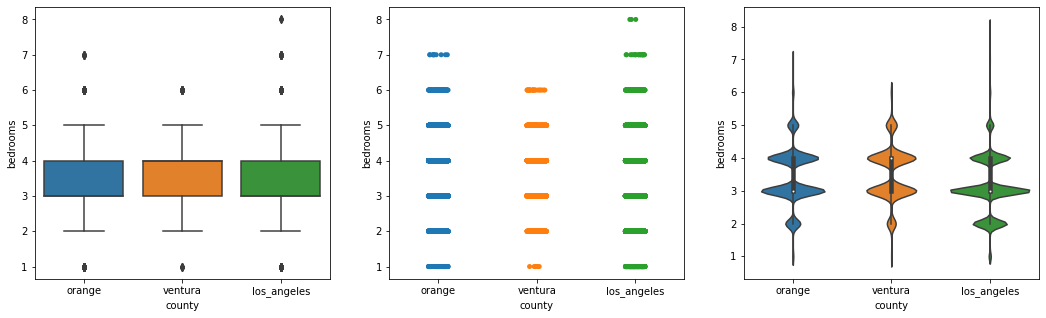

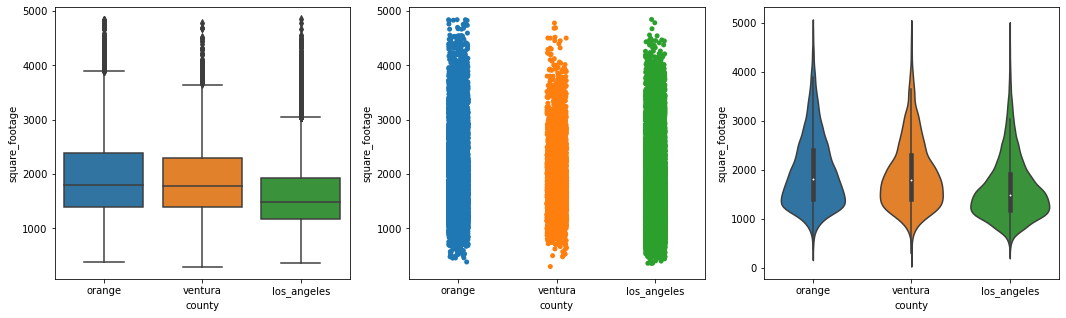

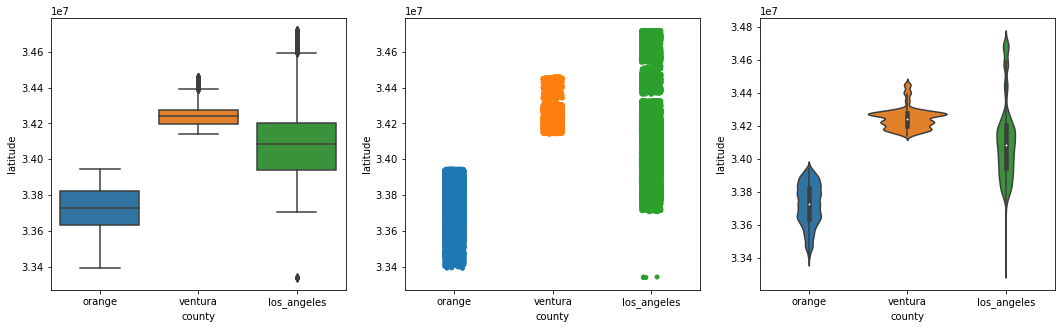

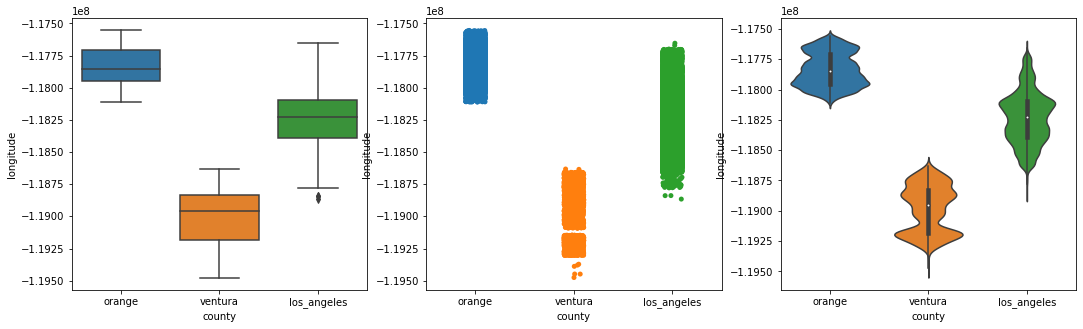

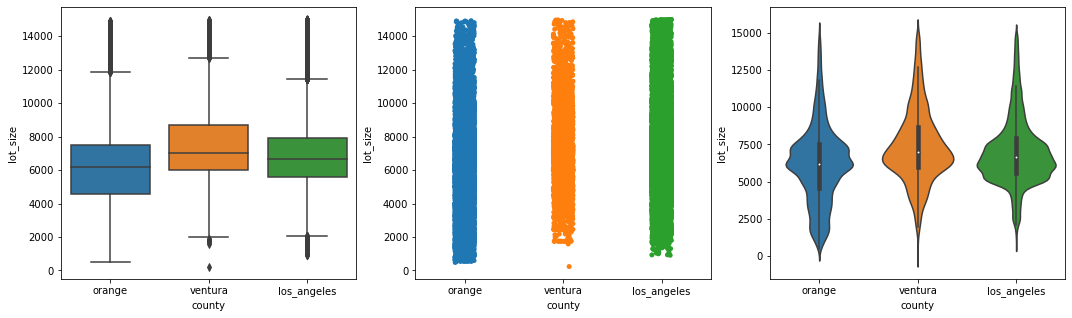

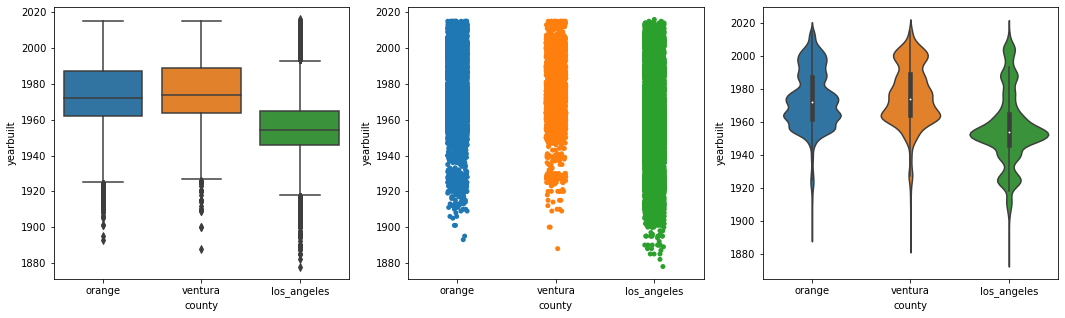

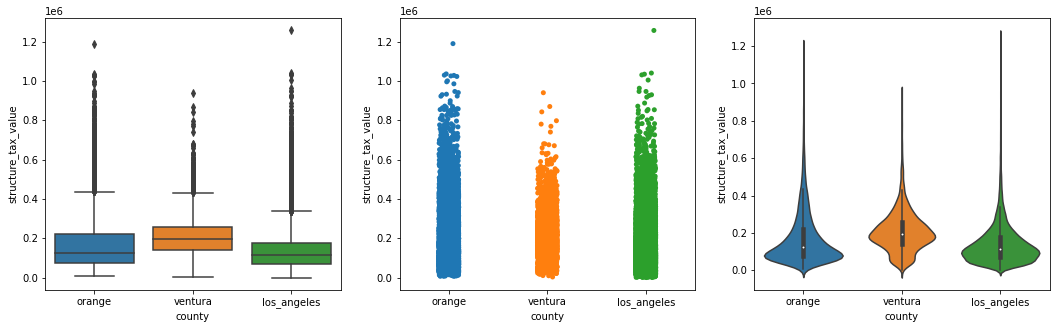

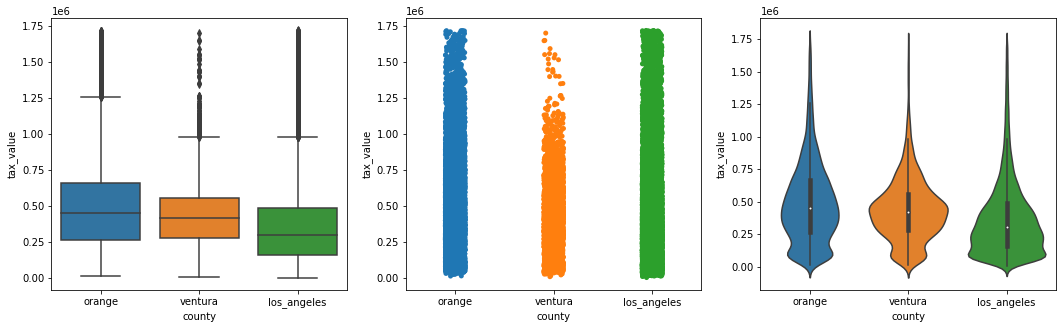

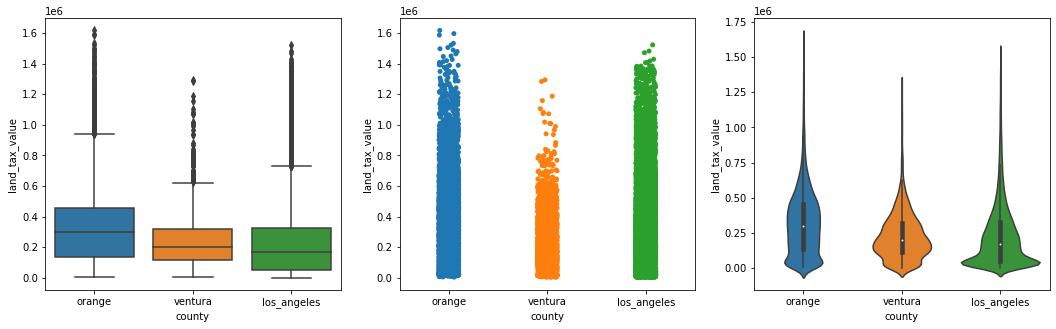

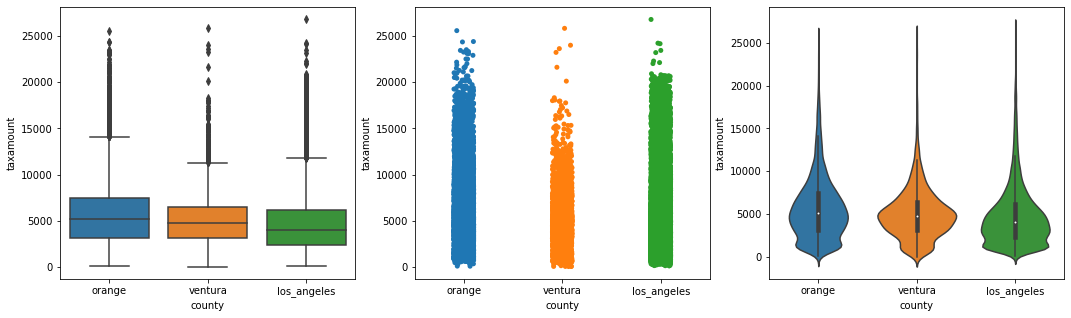

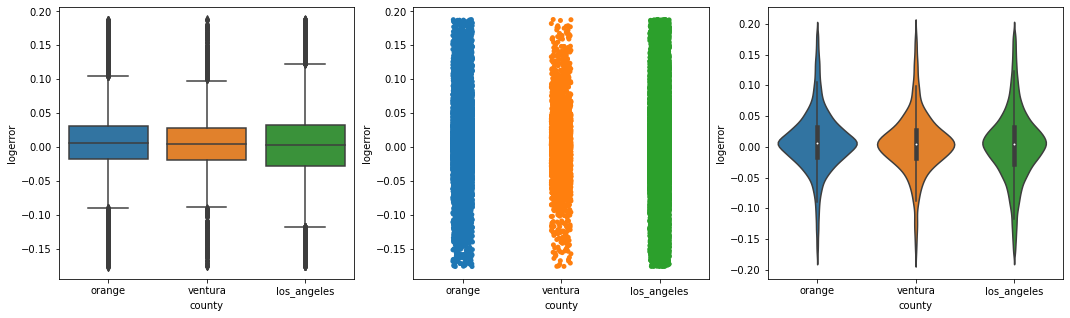

In [19]:
plot_categorical_and_continuous_vars(df, df.select_dtypes('number'), df.select_dtypes('object'))

Other notes: 

<AxesSubplot:xlabel='logerror', ylabel='Count'>

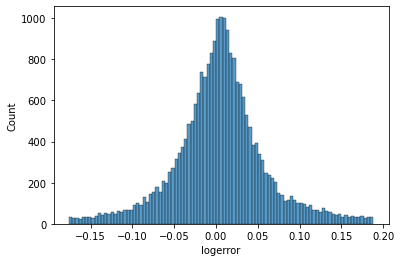

In [20]:
sns.histplot(data=train, x='logerror')

**Feature Engineering:** Going to create some synthetic features and then rerun these visualizations using those against the target to see how they perform.

- Time of year: split into 4 month blocks - Jan-Apr, May-Aug, Sept-Dec
- Time of year: seasons - Winter, Spring, Summer, Fall
- Day of week: split into days of week and see how it affects things
- Home price per square foot: structure_tax_value / square_footage
- Land price per square foot: land_tax_value / lot_size
- Yearbuilt scaled / taxamount scaled

In [21]:
# Writing a function to determine the sale time in 4 month blocks.

def four_month_split(df):
    if (df['transactiondate'] >= pd.to_datetime('2017-01-01')) and (df['transactiondate'] <  pd.to_datetime('2017-05-01')):
        return 'jan_apr'
    elif (df['transactiondate'] >= pd.to_datetime('2017-05-01')) and (df['transactiondate'] < pd.to_datetime('2017-09-01')):
        return 'may_aug'
    else:
        return 'sept_dec'
    
# Writing a function to determine the sale time in Seasons.
def season(df):
    if (df['transactiondate'] >= pd.to_datetime('2017-01-01')) and (df['transactiondate'] < pd.to_datetime('2017-03-01')) \
        or (df['transactiondate']>= pd.to_datetime('2017-12-01')):
        return 'winter'
    elif (df['transactiondate'] >= pd.to_datetime('2017-03-01')) and (df['transactiondate'] < pd.to_datetime('2017-06-01')):
        return 'spring'
    elif (df['transactiondate'] >= pd.to_datetime('2017-06-01')) and (df['transactiondate'] < pd.to_datetime('2017-09-01')):
        return 'summer'
    else:
        return 'fall' 

In [22]:
train['four_month_range'] = train.apply(four_month_split,axis=1)

In [23]:
train['season'] = train.apply(season,axis=1)

In [24]:
train[(train.transactiondate < '2017-06-01') & (train.transactiondate > '2017-04-30')].transactiondate.value_counts()

2017-05-31    249
2017-05-26    224
2017-05-19    216
2017-05-05    202
2017-05-25    173
2017-05-12    172
2017-05-23    169
2017-05-09    158
2017-05-24    149
2017-05-11    138
2017-05-16    134
2017-05-01    129
2017-05-02    127
2017-05-18    119
2017-05-08    119
2017-05-22    115
2017-05-17    113
2017-05-04    112
2017-05-10    108
2017-05-03    105
2017-05-30    105
2017-05-15    101
2017-05-29      3
2017-05-14      3
2017-05-28      2
2017-05-27      2
2017-05-21      2
2017-05-13      1
Name: transactiondate, dtype: int64

<AxesSubplot:xlabel='transactiondate', ylabel='Count'>

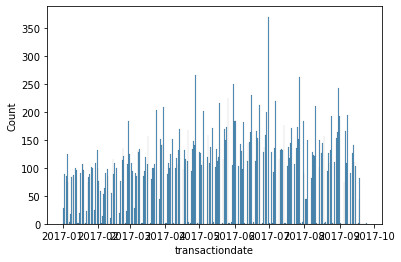

In [25]:
sns.histplot(data = train, x = 'transactiondate', bins =365)

In [26]:
train['day_of_week'] = train.transactiondate.dt.day_of_week

In [27]:
def map_days(df):
    # identified counties for fips codes 
    counties = {0: 'monday',
                1: 'tuesday',
                2: 'wednesday',
                3: 'thursday',
                4: 'friday',
                5: 'saturday',
                6: 'sunday'}
    # map counties to fips codes
    df.day_of_week = df.day_of_week.map(counties)
    return df

In [28]:
train = map_days(train)

In [29]:
train.head()

bathrooms  bedrooms  square_footage       county    latitude  \
32749        3.0         6            2684       orange  33793967.0   
3249         1.0         3            1192  los_angeles  33869289.0   
34306        2.0         3            1756  los_angeles  33898838.0   
8842         2.0         3            1893  los_angeles  34078574.0   
15342        2.5         4            2182       orange  33677270.0   

         longitude  lot_size  yearbuilt  structure_tax_value  tax_value  \
32749 -117948080.0    7189.0       1954             178500.0   362096.0   
3249  -118392007.0    4146.0       1951              79980.0   399937.0   
34306 -118019984.0    6935.0       1954             194169.0   397888.0   
8842  -118368362.0    6352.0       1927             389747.0  1679968.0   
15342 -117932340.0    9900.0       1967             164820.0   832916.0   

       land_tax_value  taxamount  logerror transactiondate four_month_range  \
32749        183596.0    4461.90  0.144139      2017-06-20          may_aug   
3249         319957.0    4560.80 -0.053424      2017-01-23          jan_apr   
34306        203719.0    5155.74  0.010691      2017-06-27          may_aug   
8842        1290221.0   20157.68  0.033177      2017-02-28          jan_apr   
15342        668096.0    9394.24 -0.142415      2017-04-03          jan_apr   

       season day_of_week  
32749  summer     tuesday  
3249   winter      monday  
34306  summer     tuesday  
8842   winter     tuesday  
15342  spring      monday

In [30]:
# Home price per square foot: structure_tax_value / square_footage
train['home_price_per_sq_ft'] = train.structure_tax_value / train.square_footage
train.head()

bathrooms  bedrooms  square_footage       county    latitude  \
32749        3.0         6            2684       orange  33793967.0   
3249         1.0         3            1192  los_angeles  33869289.0   
34306        2.0         3            1756  los_angeles  33898838.0   
8842         2.0         3            1893  los_angeles  34078574.0   
15342        2.5         4            2182       orange  33677270.0   

         longitude  lot_size  yearbuilt  structure_tax_value  tax_value  \
32749 -117948080.0    7189.0       1954             178500.0   362096.0   
3249  -118392007.0    4146.0       1951              79980.0   399937.0   
34306 -118019984.0    6935.0       1954             194169.0   397888.0   
8842  -118368362.0    6352.0       1927             389747.0  1679968.0   
15342 -117932340.0    9900.0       1967             164820.0   832916.0   

       land_tax_value  taxamount  logerror transactiondate four_month_range  \
32749        183596.0    4461.90  0.144139      2017-06-20          may_aug   
3249         319957.0    4560.80 -0.053424      2017-01-23          jan_apr   
34306        203719.0    5155.74  0.010691      2017-06-27          may_aug   
8842        1290221.0   20157.68  0.033177      2017-02-28          jan_apr   
15342        668096.0    9394.24 -0.142415      2017-04-03          jan_apr   

       season day_of_week  home_price_per_sq_ft  
32749  summer     tuesday             66.505216  
3249   winter      monday             67.097315  
34306  summer     tuesday            110.574601  
8842   winter     tuesday            205.888537  
15342  spring      monday             75.536205

In [31]:
# Land price per lot size: land_tax_value / lot_size
train['land_price_per_lot_sq_ft'] = train.land_tax_value / train.lot_size
train.head()

bathrooms  bedrooms  square_footage       county    latitude  \
32749        3.0         6            2684       orange  33793967.0   
3249         1.0         3            1192  los_angeles  33869289.0   
34306        2.0         3            1756  los_angeles  33898838.0   
8842         2.0         3            1893  los_angeles  34078574.0   
15342        2.5         4            2182       orange  33677270.0   

         longitude  lot_size  yearbuilt  structure_tax_value  tax_value  \
32749 -117948080.0    7189.0       1954             178500.0   362096.0   
3249  -118392007.0    4146.0       1951              79980.0   399937.0   
34306 -118019984.0    6935.0       1954             194169.0   397888.0   
8842  -118368362.0    6352.0       1927             389747.0  1679968.0   
15342 -117932340.0    9900.0       1967             164820.0   832916.0   

       land_tax_value  taxamount  logerror transactiondate four_month_range  \
32749        183596.0    4461.90  0.144139      2017-06-20          may_aug   
3249         319957.0    4560.80 -0.053424      2017-01-23          jan_apr   
34306        203719.0    5155.74  0.010691      2017-06-27          may_aug   
8842        1290221.0   20157.68  0.033177      2017-02-28          jan_apr   
15342        668096.0    9394.24 -0.142415      2017-04-03          jan_apr   

       season day_of_week  home_price_per_sq_ft  land_price_per_lot_sq_ft  
32749  summer     tuesday             66.505216                 25.538462  
3249   winter      monday             67.097315                 77.172455  
34306  summer     tuesday            110.574601                 29.375487  
8842   winter     tuesday            205.888537                203.120435  
15342  spring      monday             75.536205                 67.484444

In [32]:
# Yearbuilt scaled / taxamount scaled
train['scaledyear_to_scaledtax'] = train_scaled.yearbuilt / train_scaled.taxamount

In [33]:
train.head()

bathrooms  bedrooms  square_footage       county    latitude  \
32749        3.0         6            2684       orange  33793967.0   
3249         1.0         3            1192  los_angeles  33869289.0   
34306        2.0         3            1756  los_angeles  33898838.0   
8842         2.0         3            1893  los_angeles  34078574.0   
15342        2.5         4            2182       orange  33677270.0   

         longitude  lot_size  yearbuilt  structure_tax_value  tax_value  \
32749 -117948080.0    7189.0       1954             178500.0   362096.0   
3249  -118392007.0    4146.0       1951              79980.0   399937.0   
34306 -118019984.0    6935.0       1954             194169.0   397888.0   
8842  -118368362.0    6352.0       1927             389747.0  1679968.0   
15342 -117932340.0    9900.0       1967             164820.0   832916.0   

       land_tax_value  taxamount  logerror transactiondate four_month_range  \
32749        183596.0    4461.90  0.144139      2017-06-20          may_aug   
3249         319957.0    4560.80 -0.053424      2017-01-23          jan_apr   
34306        203719.0    5155.74  0.010691      2017-06-27          may_aug   
8842        1290221.0   20157.68  0.033177      2017-02-28          jan_apr   
15342        668096.0    9394.24 -0.142415      2017-04-03          jan_apr   

       season day_of_week  home_price_per_sq_ft  land_price_per_lot_sq_ft  \
32749  summer     tuesday             66.505216                 25.538462   
3249   winter      monday             67.097315                 77.172455   
34306  summer     tuesday            110.574601                 29.375487   
8842   winter     tuesday            205.888537                203.120435   
15342  spring      monday             75.536205                 67.484444   

       scaledyear_to_scaledtax  
32749                 2.966275  
3249                  2.780366  
34306                 2.563241  
8842                  0.406835  
15342                 1.653568

In [34]:
new_columns = ['four_month_range', 'season', 'day_of_week', 'home_price_per_sq_ft', 'land_price_per_lot_sq_ft', 'scaledyear_to_scaledtax']

Exploring new columns histograms.

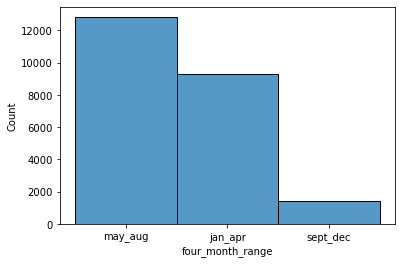

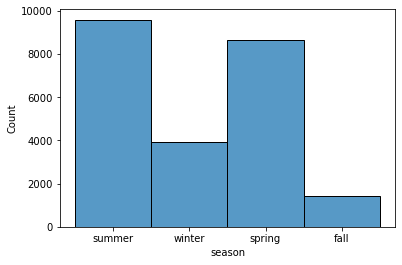

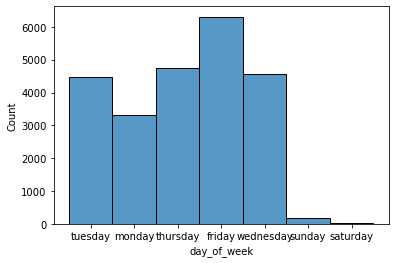

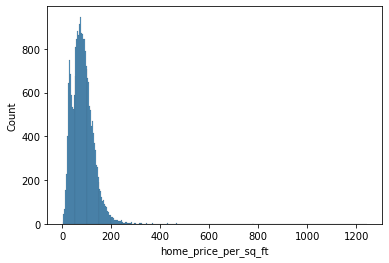

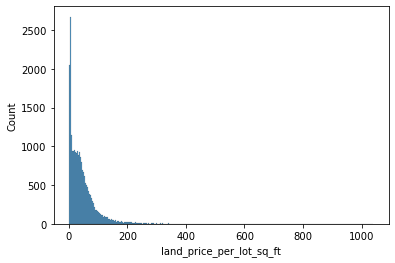

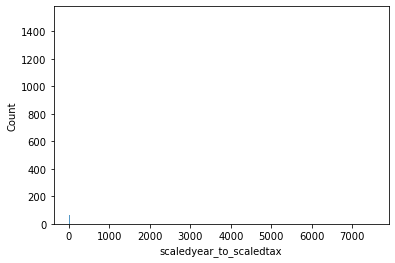

In [35]:
for column in new_columns:
    sns.histplot(data = train, x = column)
    plt.show()

### Takeaways:

- Most homes sold on Friday, nearly none sold on sat/sun.
- Most homes sold in first 2/3 of the year
- Home price per sq ft is pretty normally distributed.
- Land price per lot size has right skew
- Unsure if scaledyear to scaledtax is valuable or not.

I'm going to encode the day of weekand season to see allow me to plot these better and possibly use them in clustering or modeling.

In [36]:
def encode_columns(df, columns_to_encode):
    '''
    This function takes in a  dataframe and using one-hot encoding, encodes categorical variables. It does not drop the original
    categorical columns. This is done purposefully to allow for easier Exploratory Data Analysis.  Removal of original categorical columns
    will be done in a separate function 'drop_pre_encoded' if needed..

    Arguments: df - a dataframe with the expected feature names and columns
    Returns: encoded - a dataframe with all desired categorical columns encoded.
    '''

    dummy_df = pd.get_dummies(df[columns_to_encode], drop_first=False)
    encoded = pd.concat([df, dummy_df], axis = 1)
    return encoded

In [37]:
encoded_train = encode_columns(train, ['four_month_range', 'season', 'day_of_week'])

In [38]:
encoded_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23596 entries, 32749 to 10595
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   bathrooms                  23596 non-null  float16       
 1   bedrooms                   23596 non-null  uint8         
 2   square_footage             23596 non-null  uint16        
 3   county                     23596 non-null  object        
 4   latitude                   23596 non-null  float64       
 5   longitude                  23596 non-null  float64       
 6   lot_size                   23596 non-null  float64       
 7   yearbuilt                  23596 non-null  uint16        
 8   structure_tax_value        23596 non-null  float64       
 9   tax_value                  23596 non-null  float64       
 10  land_tax_value             23596 non-null  float64       
 11  taxamount                  23596 non-null  float64       
 12  

In [39]:
encoded_columns = ['four_month_range_may_aug', 'four_month_range_sept_dec','four_month_range_jan_apr', 'season_spring',
                  'season_summer','season_winter','season_fall','day_of_week_monday','day_of_week_saturday', 'day_of_week_sunday',
                  'day_of_week_thursday', 'day_of_week_tuesday', 'day_of_week_wednesday','day_of_week_friday']

Plotting new columns against logerror to see if anything pops out.

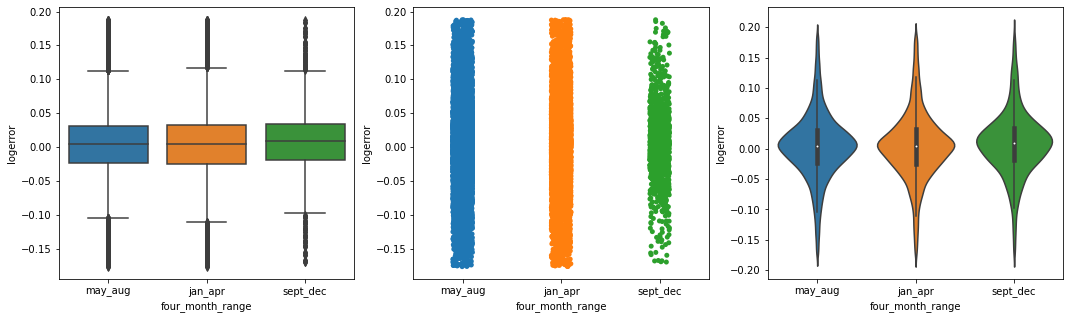

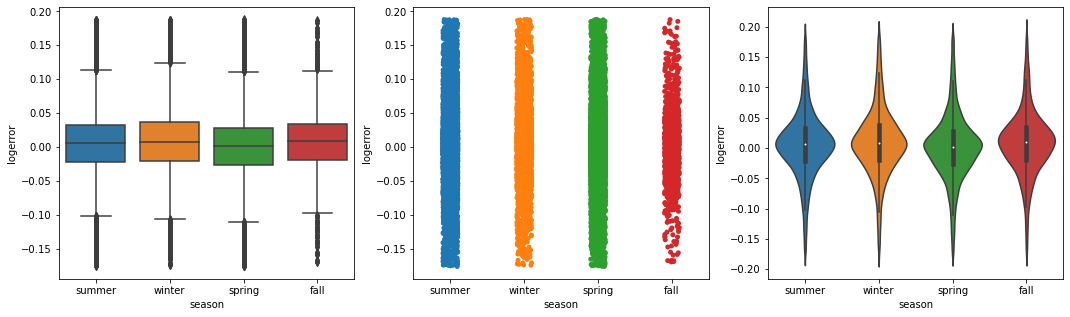

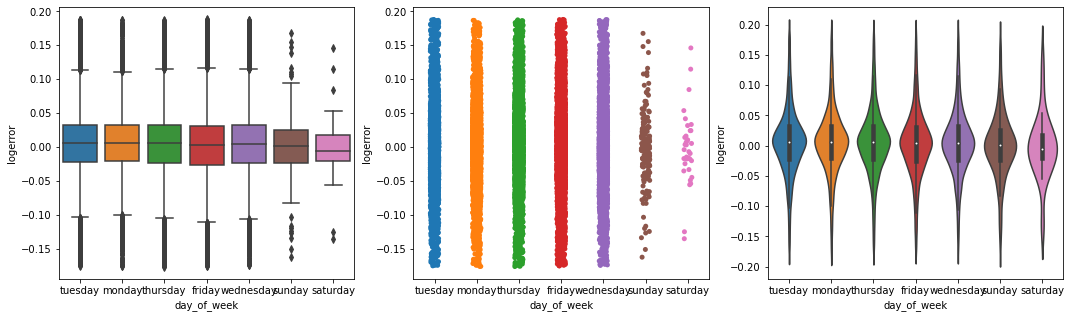

<Figure size 720x360 with 0 Axes>

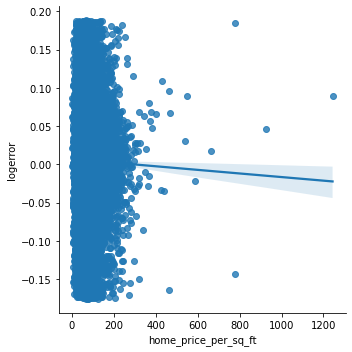

<Figure size 720x360 with 0 Axes>

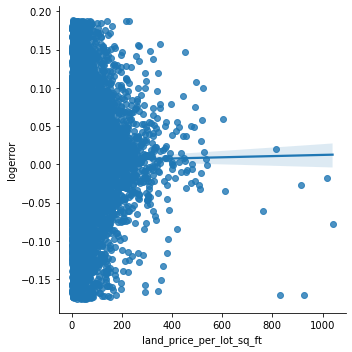

<Figure size 720x360 with 0 Axes>

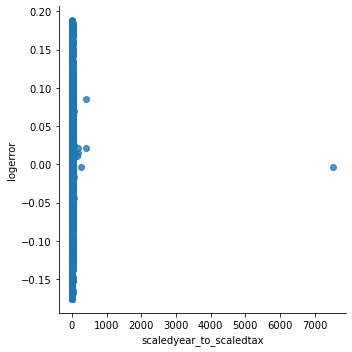

In [40]:
for column in new_columns:
    if train[column].dtype == np.number:
        plt.figure(figsize=(10,5))
        sns.lmplot(data = train, x = column, y = 'logerror')
        plt.show()
    else:
        plt.figure(figsize=(18, 5))
        plt.subplot(131)
        sns.boxplot(x=column, y='logerror', data=train)
        plt.subplot(132)
        sns.stripplot(x=column, y='logerror', data=train)
        plt.subplot(133)
        sns.violinplot(x=column, y='logerror', data=train)
        plt.show()

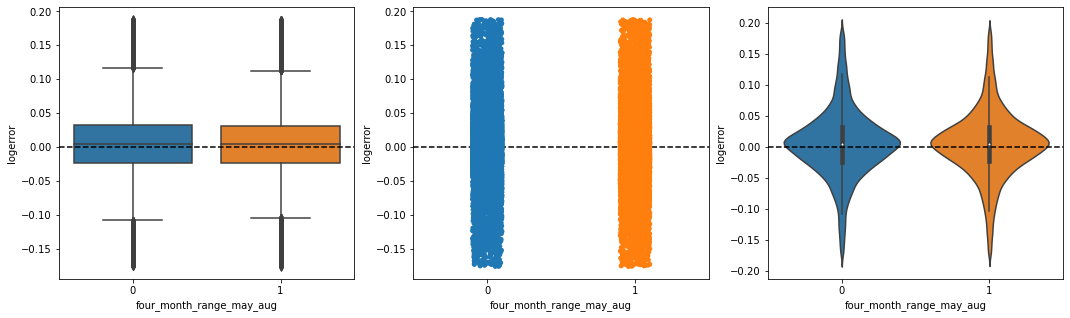

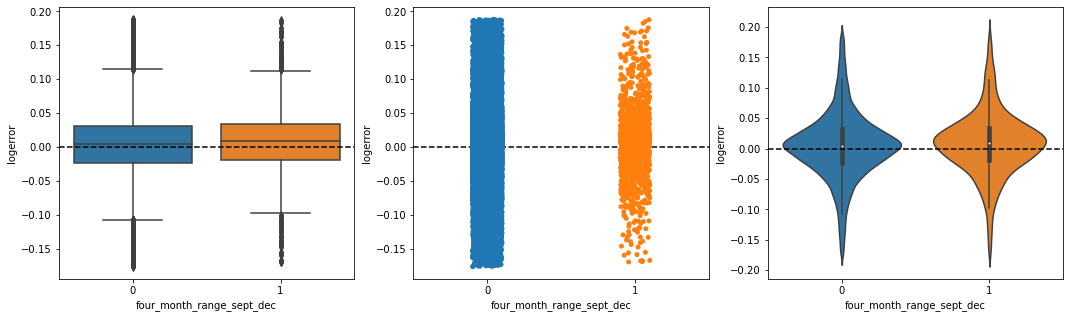

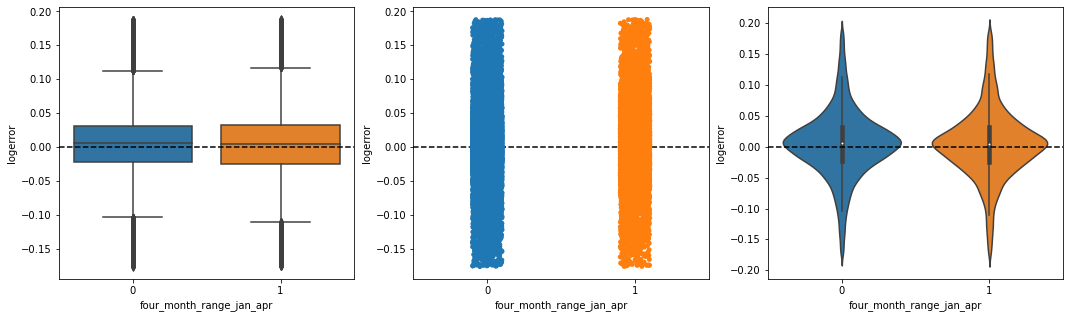

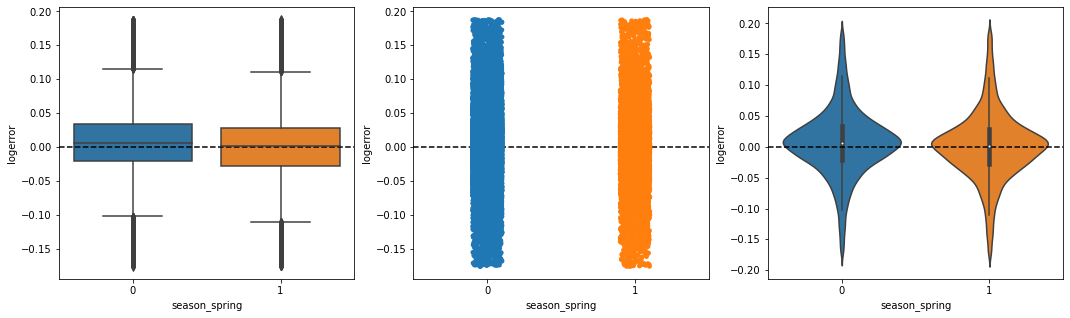

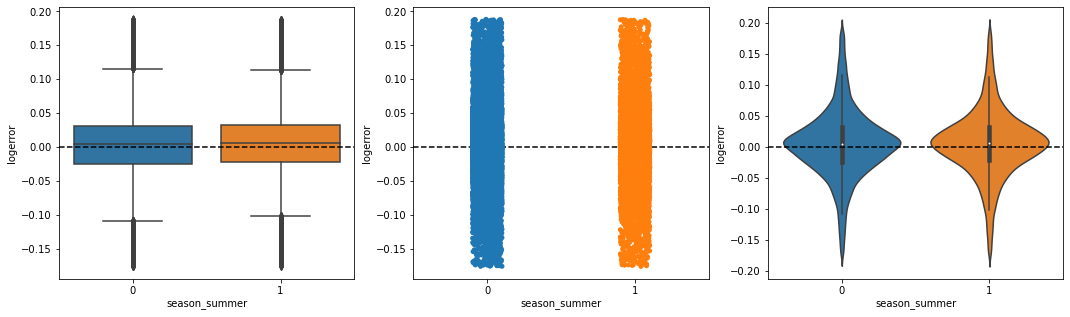

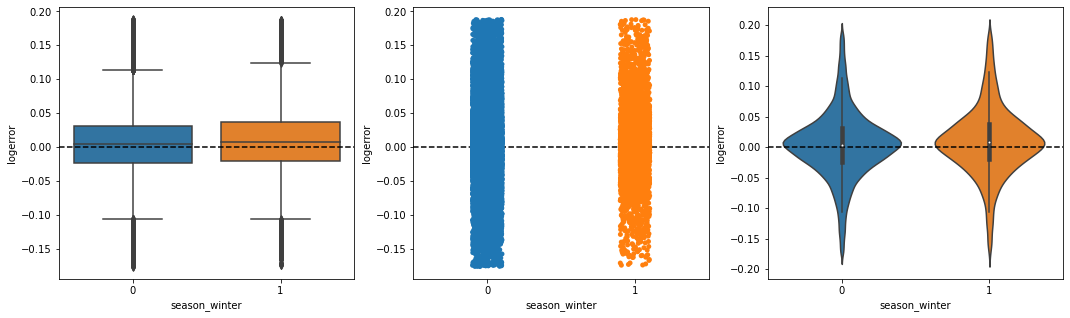

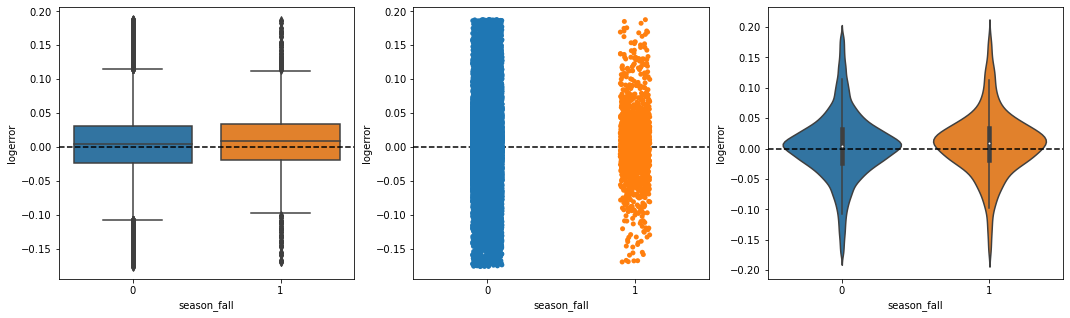

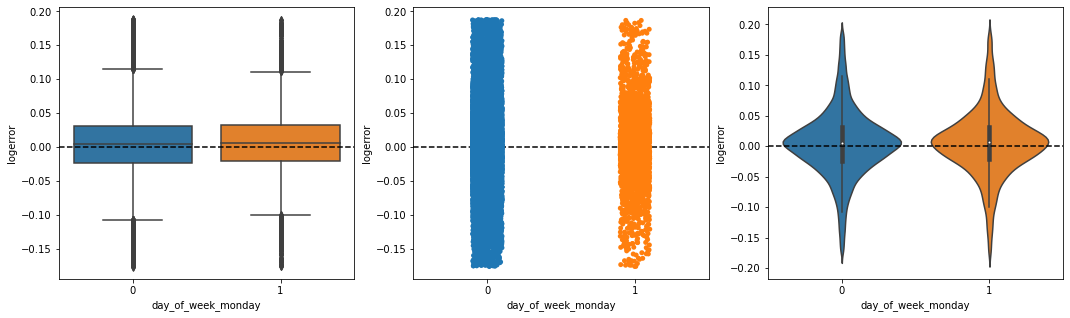

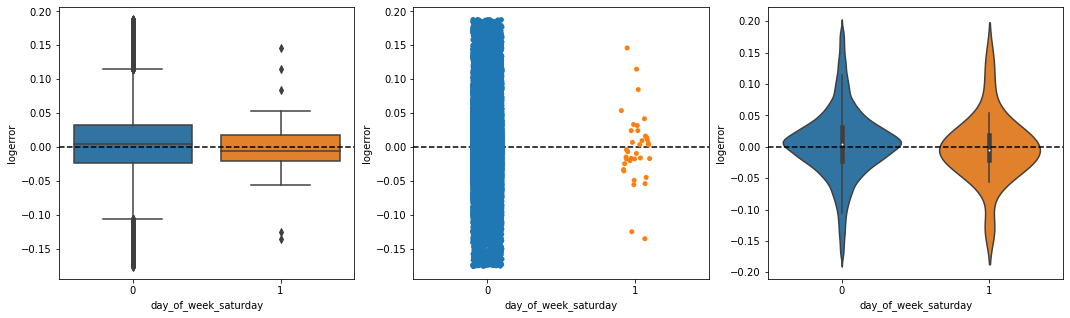

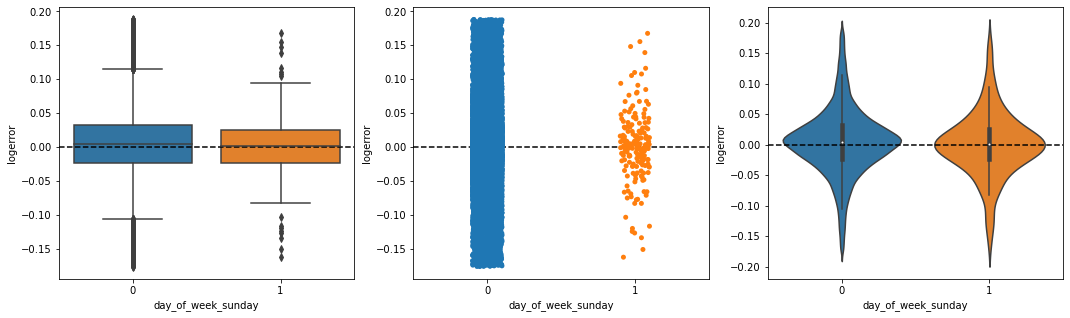

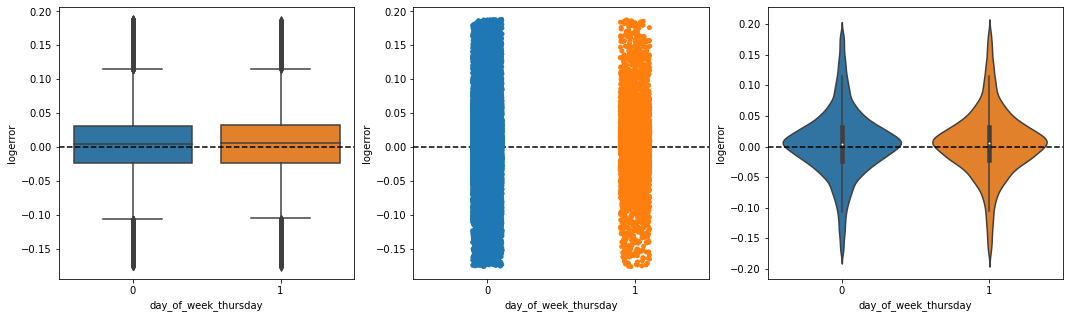

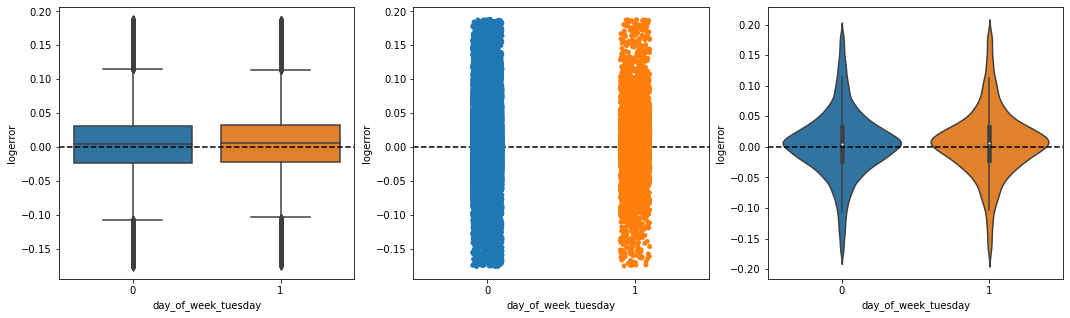

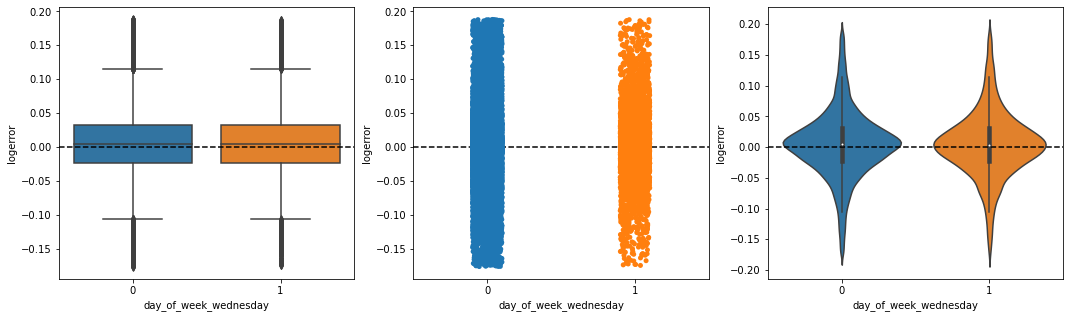

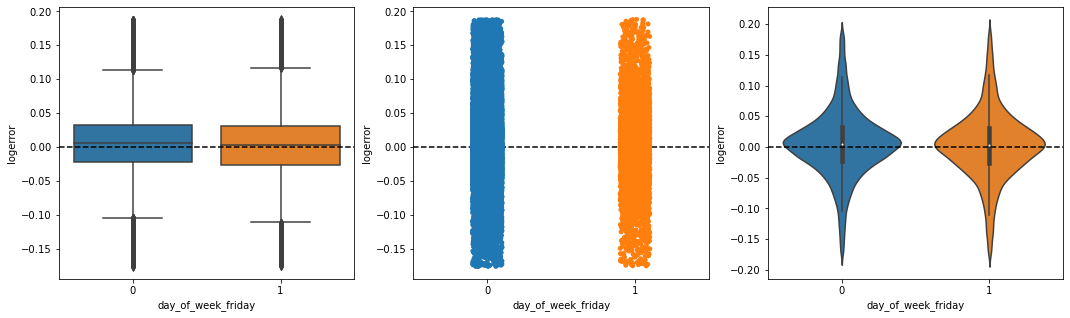

In [41]:
for column in encoded_columns:
    if encoded_train[column].dtype == np.number:
        plt.figure(figsize=(10,5))
        sns.lmplot(data = encoded_train, x = column, y = 'logerror')
        plt.show()
    else:
        plt.figure(figsize=(18, 5))
        plt.subplot(131)
        sns.boxplot(x=column, y='logerror', data=encoded_train)
        plt.axhline(0, color = 'black', ls = "--")
        plt.subplot(132)
        sns.stripplot(x=column, y='logerror', data=encoded_train)
        plt.axhline(0, color = 'black', ls = "--")
        plt.subplot(133)
        sns.violinplot(x=column, y='logerror', data=encoded_train)
        plt.axhline(0, color = 'black', ls = "--")
        plt.show()

**Takeaways**

The only thing that stood out to me from visual inspection was that *maybe* spring had a lower logerror overall than the rest of the population.

Also maybe four_month_range_sept_dec (or season_fall) might've had a higher logerror overall than the rest of the population. I can test both these observations here with t-tests.


##### Hypothesis 1
alpha = .05

$H_{0}$ = The logerror for homes sold in the Spring months is equal to or higher than homes sold in the other months.

$H_{a}$ = The logerror for homes sold in the Spring months is lower than homes sold in the other months.

In [42]:
spring_homes = train[train.season == "spring"]
nonspring_homes = train[train.season != "spring"]

# Setting alpha
alpha = .05

In [43]:
#Testing for variance with levene
stats.levene(spring_homes.logerror, nonspring_homes.logerror)

LeveneResult(statistic=1.5234484767578338, pvalue=0.217110674221071)

In [44]:
# Based on the Levene test above I need to set equal_var = False

# Running ttest to see if mean of logerror for homes sold in the spring is different than the entire population.
stats.ttest_ind(spring_homes.logerror, nonspring_homes.logerror, equal_var=False)

Ttest_indResult(statistic=-6.84335547108009, pvalue=7.988704917068004e-12)

I reject the null hypothesis, the logerror for homes sold in the Spring months is statistically significant lower than homes sold in the other months.

Visualization below.

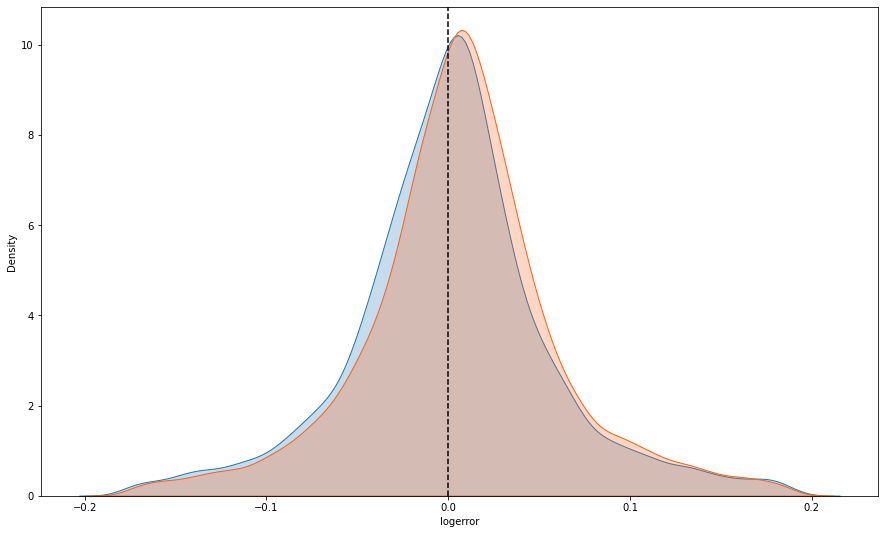

In [45]:
plt.figure(figsize=(15,9))
sns.kdeplot(data = spring_homes, x = 'logerror', shade=True)
sns.kdeplot(data = nonspring_homes, x = 'logerror', color = '#FF5E13', shade= True)
plt.axvline(0, c='black', ls = '--')
plt.show()

Before running a hypothesis test for four_month_range_sept_dec I want to compare it to season fall as they were both larger than the rest of their categories

In [46]:
sept_dec_homes = train[train.four_month_range == 'sept_dec']
fall_homes = train[train.season == 'fall']
non_fall_homes = train[train.season != 'fall']

In [47]:
sept_dec_homes.logerror.describe(), fall_homes.logerror.describe()

(count    1436.000000
 mean        0.008471
 std         0.052555
 min        -0.169302
 25%        -0.019208
 50%         0.009535
 75%         0.034113
 max         0.187886
 Name: logerror, dtype: float64,
 count    1436.000000
 mean        0.008471
 std         0.052555
 min        -0.169302
 25%        -0.019208
 50%         0.009535
 75%         0.034113
 max         0.187886
 Name: logerror, dtype: float64)

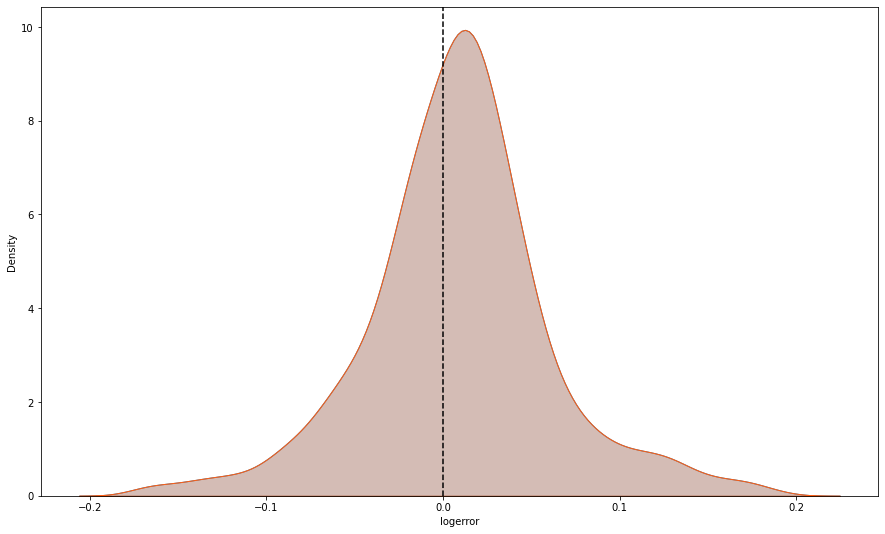

In [48]:
plt.figure(figsize=(15,9))
sns.kdeplot(data = sept_dec_homes, x = 'logerror', shade=True)
sns.kdeplot(data = fall_homes, x = 'logerror', color = '#FF5E13', shade= True)
plt.axvline(0, c='black', ls = '--')
plt.show()

As we see visually and statiscally this is the *exact* same data. So for in keepng it with the season from above, I'll use the fall homes category and compare that to non fall homes.

##### Hypothesis 2
alpha = .05

$H_{0}$ = The logerror for homes sold in the Fall months is equal to or lower than homes sold in the other months.

$H_{a}$ = The logerror for homes sold in the Fall months is higher than homes sold in the other months.

In [49]:
#Testing for variance with levene
stats.levene(fall_homes.logerror, non_fall_homes.logerror)

LeveneResult(statistic=3.3469620155606954, pvalue=0.06734177945935858)

In [50]:
# Based on the Levene test above I can leave equal_var = True

# Running ttest to see if mean of logerror for homes sold in the fall is different than the entire population.
stats.ttest_ind(fall_homes.logerror, non_fall_homes.logerror, equal_var=True)

Ttest_indResult(statistic=2.549768795643936, pvalue=0.010785704405451195)

I reject the null hypothesis and determine that homes sold in the Fall months have a statistically significant higher logerror than homes sold in the other months. 

Visualization below.

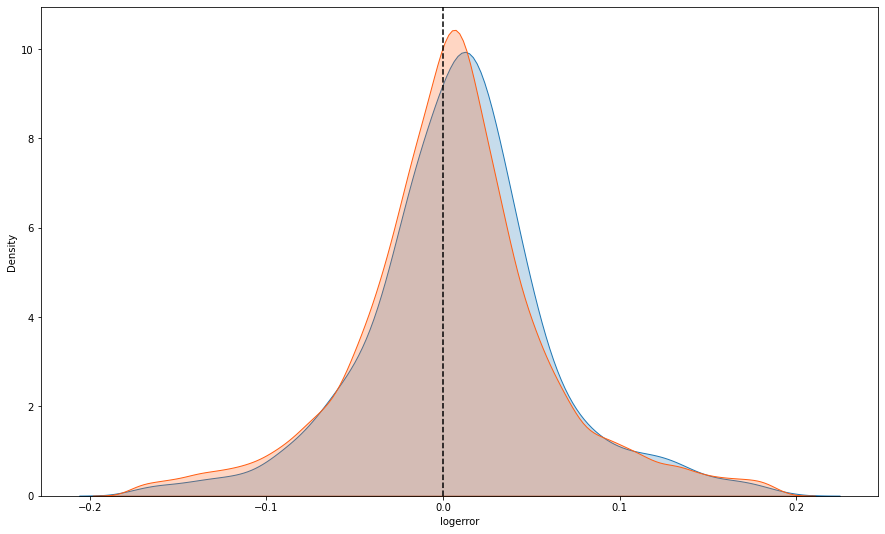

In [51]:
plt.figure(figsize=(15,9))
sns.kdeplot(data = fall_homes, x = 'logerror', shade=True)
sns.kdeplot(data = non_fall_homes, x = 'logerror', color = '#FF5E13', shade= True)
plt.axvline(0, c='black', ls = '--')
plt.show()

##### Takeaways
From these two hypothesis tests I can determine the following.
- Homes sold in the Spring have a statistically signficant logerror that is lower than the rest of the year.
- Homes sold in the Fall have a statistically signficant logerror that is higher than the rest of the year.

I will include both of these features in my final model.

Looking at a heatmap of all the things now.

<AxesSubplot:>

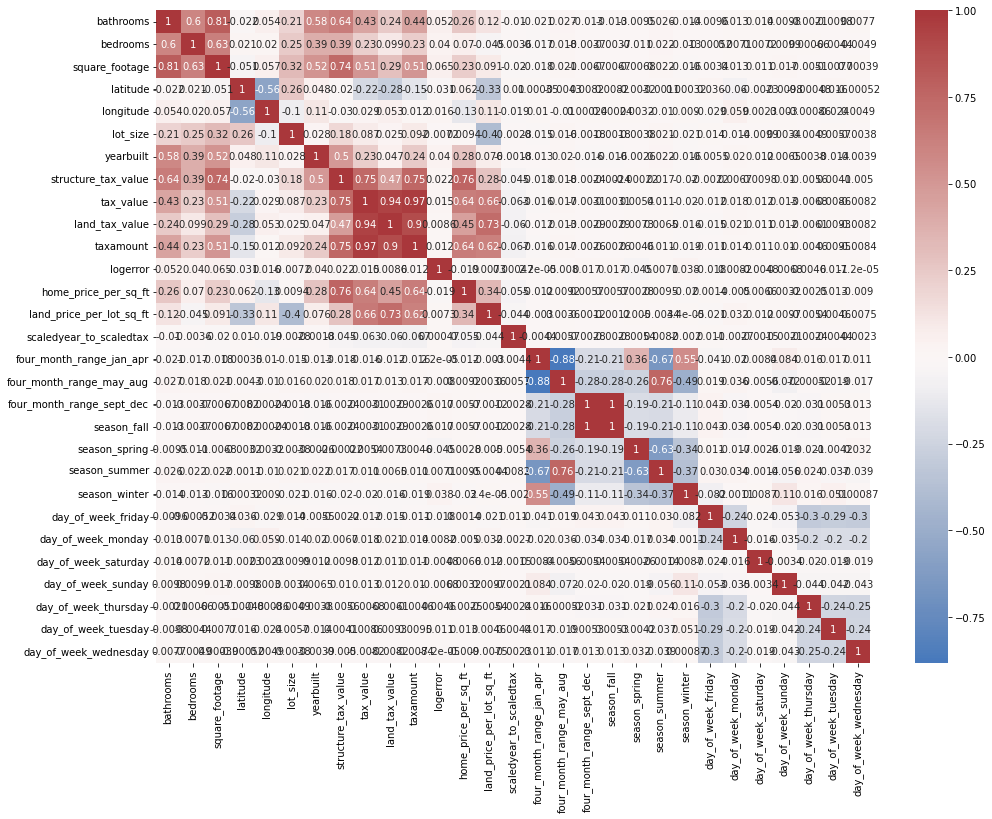

In [52]:
plt.figure(figsize=(16,12))
sns.heatmap(encoded_train.corr(), annot=True, center = 0, cmap='vlag')

None of the new features created correlate directly with logerror.

## Clustering

I need to do a bit of preprocessing before I cluster.

1) I need to add my new encoded features to my scaled dataframe.
    - This consists of all the columns having to do with season, day of week, and month group.

2) I need to add my new feature columns that are numerical to my scaled dataframe.
    - I need to scale these as well.

In [53]:
encoded_train[encoded_columns]

four_month_range_may_aug  four_month_range_sept_dec  \
32749                         1                          0   
3249                          0                          0   
34306                         1                          0   
8842                          0                          0   
15342                         0                          0   
...                         ...                        ...   
33532                         1                          0   
13516                         0                          0   
19325                         0                          0   
7775                          0                          0   
10595                         0                          0   

       four_month_range_jan_apr  season_spring  season_summer  season_winter  \
32749                         0              0              1              0   
3249                          1              0              0              1   
34306                         0              0              1              0   
8842                          1              0              0              1   
15342                         1              1              0              0   
...                         ...            ...            ...            ...   
33532                         0              0              1              0   
13516                         1              1              0              0   
19325                         1              1              0              0   
7775                          1              0              0              1   
10595                         1              1              0              0   

       season_fall  day_of_week_monday  day_of_week_saturday  \
32749            0                   0                     0   
3249             0                   1                     0   
34306            0                   0                     0   
8842             0                   0                     0   
15342            0                   1                     0   
...            ...                 ...                   ...   
33532            0                   0                     0   
13516            0                   0                     0   
19325            0                   0                     1   
7775             0                   0                     0   
10595            0                   0                     0   

       day_of_week_sunday  day_of_week_thursday  day_of_week_tuesday  \
32749                   0                     0                    1   
3249                    0                     0                    0   
34306                   0                     0                    1   
8842                    0                     0                    1   
15342                   0                     0                    0   
...                   ...                   ...                  ...   
33532                   0                     0                    0   
13516                   0                     0                    0   
19325                   0                     0                    0   
7775                    0                     1                    0   
10595                   0                     1                    0   

       day_of_week_wednesday  day_of_week_friday  
32749                      0                   0  
3249                       0                   0  
34306                      0                   0  
8842                       0                   0  
15342                      0                   0  
...                      ...                 ...  
33532                      0                   1  
13516                      0                   1  
19325                      0                   0  
7775                       0                   0  
10595                      0                   0  

[23596 rows x 14 columns]

In [54]:
train_scaled[encoded_columns] = encoded_train[encoded_columns]

In [55]:
# Encoded data added.
train_scaled.head()

bathrooms  bedrooms  square_footage       county  latitude  longitude  \
32749   0.571429  0.714286        0.525110       orange  0.301536   0.792241   
3249    0.000000  0.285714        0.196476  los_angeles  0.358449   0.557825   
34306   0.285714  0.285714        0.320705  los_angeles  0.380776   0.754272   
8842    0.285714  0.285714        0.350881  los_angeles  0.516583   0.570311   
15342   0.428571  0.428571        0.414537       orange  0.213360   0.800553   

       lot_size  yearbuilt  structure_tax_value  tax_value  ...  \
32749  0.462530   0.537313             0.141515   0.205502  ...   
3249   0.252740   0.514925             0.063064   0.227619  ...   
34306  0.445019   0.537313             0.153992   0.226422  ...   
8842   0.404826   0.335821             0.309730   0.975783  ...   
15342  0.649431   0.634328             0.130621   0.480691  ...   

       season_summer  season_winter  season_fall day_of_week_monday  \
32749              1              0            0                  0   
3249               0              1            0                  1   
34306              1              0            0                  0   
8842               0              1            0                  0   
15342              0              0            0                  1   

       day_of_week_saturday  day_of_week_sunday  day_of_week_thursday  \
32749                     0                   0                     0   
3249                      0                   0                     0   
34306                     0                   0                     0   
8842                      0                   0                     0   
15342                     0                   0                     0   

       day_of_week_tuesday  day_of_week_wednesday  day_of_week_friday  
32749                    1                      0                   0  
3249                     0                      0                   0  
34306                    1                      0                   0  
8842                     1                      0                   0  
15342                    0                      0                   0  

[5 rows x 28 columns]

In [61]:
train_scaled[['home_price_per_sq_ft', 'land_price_per_lot_sq_ft', 'scaledyear_to_scaledtax']] = train[['home_price_per_sq_ft', 'land_price_per_lot_sq_ft', 'scaledyear_to_scaledtax']]

In [62]:
train_scaled.head()

bathrooms  bedrooms  square_footage       county  latitude  longitude  \
32749   0.571429  0.714286        0.525110       orange  0.301536   0.792241   
3249    0.000000  0.285714        0.196476  los_angeles  0.358449   0.557825   
34306   0.285714  0.285714        0.320705  los_angeles  0.380776   0.754272   
8842    0.285714  0.285714        0.350881  los_angeles  0.516583   0.570311   
15342   0.428571  0.428571        0.414537       orange  0.213360   0.800553   

       lot_size  yearbuilt  structure_tax_value  tax_value  ...  \
32749  0.462530   0.537313             0.141515   0.205502  ...   
3249   0.252740   0.514925             0.063064   0.227619  ...   
34306  0.445019   0.537313             0.153992   0.226422  ...   
8842   0.404826   0.335821             0.309730   0.975783  ...   
15342  0.649431   0.634328             0.130621   0.480691  ...   

       day_of_week_monday  day_of_week_saturday  day_of_week_sunday  \
32749                   0                     0                   0   
3249                    1                     0                   0   
34306                   0                     0                   0   
8842                    0                     0                   0   
15342                   1                     0                   0   

      day_of_week_thursday  day_of_week_tuesday  day_of_week_wednesday  \
32749                    0                    1                      0   
3249                     0                    0                      0   
34306                    0                    1                      0   
8842                     0                    1                      0   
15342                    0                    0                      0   

       day_of_week_friday  scaledyear_to_scaledtax  home_price_per_sq_ft  \
32749                   0                 2.966275             66.505216   
3249                    0                 2.780366             67.097315   
34306                   0                 2.563241            110.574601   
8842                    0                 0.406835            205.888537   
15342                   0                 1.653568             75.536205   

       land_price_per_lot_sq_ft  
32749                 25.538462  
3249                  77.172455  
34306                 29.375487  
8842                 203.120435  
15342                 67.484444  

[5 rows x 31 columns]

In [63]:
from sklearn.preprocessing import MinMaxScaler

def temp_data_scaler(df, columns_to_scale):
    '''
    This function takes in train, validate, test subsets of the cleaned zillow dataset and using the train subset creates a min_max 
    scaler. It thens scales the subsets and returns the train, validate, test subsets as scaled versions of the initial data.

    Arguments:  train, validate, test - split subsets from of the cleaned zillow dataframe
                columns_to_scale - a list of column names to scale
    Return: scaled_train, scaled_validate, scaled_test - dataframe with scaled versions of the initial unscaled dataframes 
    '''
    df_scaled = df.copy()
    
    scaler = MinMaxScaler()
    
    df_scaled[columns_to_scale] = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), 
                                                  columns=df[columns_to_scale].columns.values).set_index([df.index.values])
    return df_scaled

In [115]:
train_scaled = train_scaled[train.scaledyear_to_scaledtax != np.inf]

In [118]:
train_scaled = temp_data_scaler(train_scaled, columns_to_scale= ['home_price_per_sq_ft', 'land_price_per_lot_sq_ft', 'scaledyear_to_scaledtax'])

# scaler = MinMaxScaler()
# scaler.fit_transform(train_scaled[train_scaled.select_dtypes('number').columns.tolist()])


In [119]:
train_scaled.head()

bathrooms  bedrooms  square_footage       county  latitude  longitude  \
32749   0.571429  0.714286        0.525110       orange  0.301536   0.792241   
3249    0.000000  0.285714        0.196476  los_angeles  0.358449   0.557825   
34306   0.285714  0.285714        0.320705  los_angeles  0.380776   0.754272   
8842    0.285714  0.285714        0.350881  los_angeles  0.516583   0.570311   
15342   0.428571  0.428571        0.414537       orange  0.213360   0.800553   

       lot_size  yearbuilt  structure_tax_value  tax_value  ...  \
32749  0.462530   0.537313             0.141515   0.205502  ...   
3249   0.252740   0.514925             0.063064   0.227619  ...   
34306  0.445019   0.537313             0.153992   0.226422  ...   
8842   0.404826   0.335821             0.309730   0.975783  ...   
15342  0.649431   0.634328             0.130621   0.480691  ...   

       day_of_week_monday  day_of_week_saturday  day_of_week_sunday  \
32749                   0                     0                   0   
3249                    1                     0                   0   
34306                   0                     0                   0   
8842                    0                     0                   0   
15342                   1                     0                   0   

      day_of_week_thursday  day_of_week_tuesday  day_of_week_wednesday  \
32749                    0                    1                      0   
3249                     0                    0                      0   
34306                    0                    1                      0   
8842                     0                    1                      0   
15342                    0                    0                      0   

       day_of_week_friday  scaledyear_to_scaledtax  home_price_per_sq_ft  \
32749                   0                 0.000395              0.052488   
3249                    0                 0.000370              0.052964   
34306                   0                 0.000341              0.087970   
8842                    0                 0.000054              0.164712   
15342                   0                 0.000220              0.059759   

       land_price_per_lot_sq_ft  
32749                  0.024365  
3249                   0.074019  
34306                  0.028055  
8842                   0.195138  
15342                  0.064702  

[5 rows x 31 columns]

In [122]:
train_scaled.describe().T

count      mean       std       min       25%  \
bathrooms                  23595.0  0.326746  0.222554  0.000000  0.285714   
bedrooms                   23595.0  0.318742  0.122136  0.000000  0.285714   
square_footage             23595.0  0.317260  0.150111  0.000000  0.207930   
latitude                   23595.0  0.466196  0.207246  0.000000  0.319526   
longitude                  23595.0  0.670197  0.188806  0.000000  0.564166   
lot_size                   23595.0  0.435404  0.164978  0.000000  0.339400   
yearbuilt                  23595.0  0.603386  0.166889  0.000000  0.507463   
structure_tax_value        23595.0  0.121605  0.092839  0.000000  0.058445   
tax_value                  23595.0  0.233412  0.175262  0.000000  0.103591   
land_tax_value             23595.0  0.159354  0.141995  0.000000  0.043627   
taxamount                  23595.0  0.205902  0.143002  0.000085  0.104433   
logerror                   23595.0  0.496669  0.151210  0.000000  0.419147   
four_month_range_may_aug   23595.0  0.544141  0.498058  0.000000  0.000000   
four_month_range_sept_dec  23595.0  0.060860  0.239079  0.000000  0.000000   
four_month_range_jan_apr   23595.0  0.394999  0.488861  0.000000  0.000000   
season_spring              23595.0  0.365967  0.481711  0.000000  0.000000   
season_summer              23595.0  0.406400  0.491171  0.000000  0.000000   
season_winter              23595.0  0.166773  0.372781  0.000000  0.000000   
season_fall                23595.0  0.060860  0.239079  0.000000  0.000000   
day_of_week_monday         23595.0  0.140623  0.347640  0.000000  0.000000   
day_of_week_saturday       23595.0  0.001526  0.039032  0.000000  0.000000   
day_of_week_sunday         23595.0  0.007629  0.087011  0.000000  0.000000   
day_of_week_thursday       23595.0  0.201229  0.400927  0.000000  0.000000   
day_of_week_tuesday        23595.0  0.188981  0.391502  0.000000  0.000000   
day_of_week_wednesday      23595.0  0.192837  0.394535  0.000000  0.000000   
day_of_week_friday         23595.0  0.267175  0.442494  0.000000  0.000000   
scaledyear_to_scaledtax    23595.0  0.000693  0.006557  0.000000  0.000297   
home_price_per_sq_ft       23595.0  0.066663  0.035929  0.000000  0.042436   
land_price_per_lot_sq_ft   23595.0  0.043216  0.050117  0.000000  0.010009   

                                50%       75%  max  
bathrooms                  0.285714  0.571429  1.0  
bedrooms                   0.285714  0.428571  1.0  
square_footage             0.283260  0.394824  1.0  
latitude                   0.453617  0.596372  1.0  
longitude                  0.696675  0.806490  1.0  
lot_size                   0.418614  0.507894  1.0  
yearbuilt                  0.582090  0.716418  1.0  
structure_tax_value        0.097400  0.156230  1.0  
tax_value                  0.199601  0.316613  1.0  
land_tax_value             0.128415  0.230431  1.0  
taxamount                  0.179154  0.268660  1.0  
logerror                   0.497150  0.570906  1.0  
four_month_range_may_aug   1.000000  1.000000  1.0  
four_month_range_sept_dec  0.000000  0.000000  1.0  
four_month_range_jan_apr   0.000000  1.000000  1.0  
season_spring              0.000000  1.000000  1.0  
season_summer              0.000000  1.000000  1.0  
season_winter              0.000000  0.000000  1.0  
season_fall                0.000000  0.000000  1.0  
day_of_week_monday         0.000000  0.000000  1.0  
day_of_week_saturday       0.000000  0.000000  1.0  
day_of_week_sunday         0.000000  0.000000  1.0  
day_of_week_thursday       0.000000  0.000000  1.0  
day_of_week_tuesday        0.000000  0.000000  1.0  
day_of_week_wednesday      0.000000  0.000000  1.0  
day_of_week_friday         0.000000  1.000000  1.0  
scaledyear_to_scaledtax    0.000440  0.000769  1.0  
home_price_per_sq_ft       0.062947  0.085958  1.0  
land_price_per_lot_sq_ft   0.030871  0.057490  1.0

Data scaled and ready to find clusers with KMeans.

In [124]:
test_results = pd.DataFrame()

In [134]:
X = train_scaled[['home_price_per_sq_ft', 'tax_value', 'lot_size']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

test_results['first_cluster'] = kmeans.predict(X)

<AxesSubplot:xlabel='tax_value', ylabel='lot_size'>

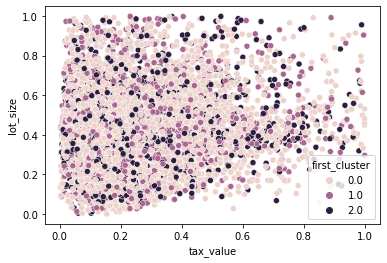

In [135]:
sns.scatterplot(x= train_scaled.tax_value, y = train_scaled.lot_size, hue =test_results.first_cluster)

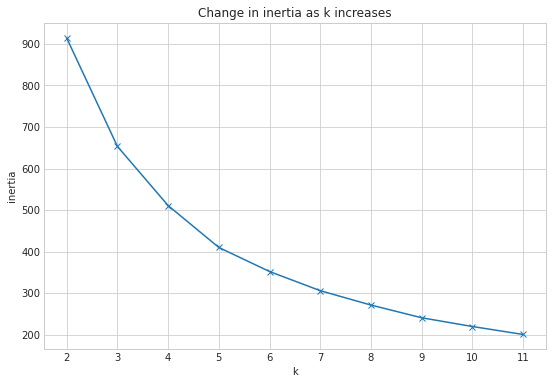

In [128]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
